<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [6]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [7]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [8]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [9]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [12]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [13]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [15]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

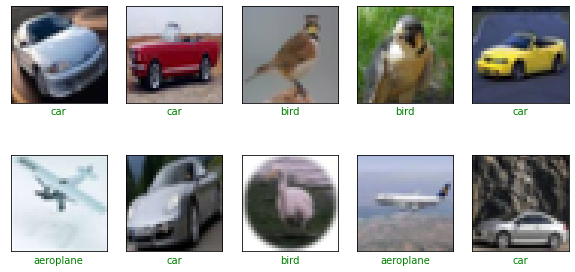

In [16]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [17]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [18]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [19]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [20]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 1: DNN with 2 layers (no regularization)

Hidden layer 1: 100 neurons

Hidden layer 2: 150 neurons

Ouput layer: 10 neurons (one for each image)

####Build, Compile, Train, Evaluate

In [21]:
## Variation 1 - did not train
#model_1 = Sequential()
#model_1.add(Dense(input_shape = [32,32,3], units = 100, activation = 'relu', ))
#model_1.add(Dense(units = 150, activation = 'relu'))
#model_1.add(Dense(name = "output_layer", units = 10, activation = 'softmax'))
#model_1.summary()

In [22]:
## Variation 2 - trained 
model_1 = Sequential()
model_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_1.add(layers.Dense(units = 100, activation = "relu"))
model_1.add(layers.Dense(units = 150, activation = "relu"))
model_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-trainable params: 0
_________________________________________________________________


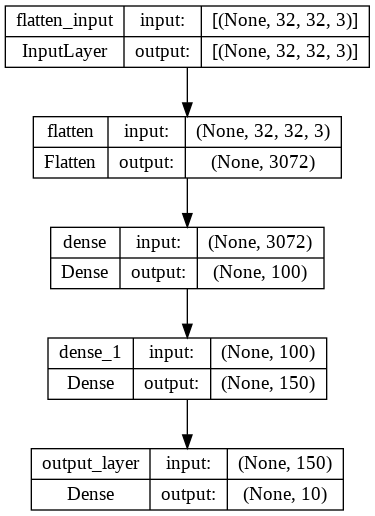

In [23]:
keras.utils.plot_model(model_1, "CIFAR_model.png", show_shapes=True) 

In [24]:
## Compile

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
## Train 

history_1 = model_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 5s 3ms/step - loss: 1.8686 - accuracy: 0.3213 - val_loss: 1.7443 - val_accuracy: 0.3554
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6898 - accuracy: 0.3941 - val_loss: 1.6687 - val_accuracy: 0.4044
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6138 - accuracy: 0.4209 - val_loss: 1.6631 - val_accuracy: 0.3974
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5685 - accuracy: 0.4388 - val_loss: 1.6250 - val_accuracy: 0.4028
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5328 - accuracy: 0.4529 - val_loss: 1.5467 - val_accuracy: 0.4382
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5044 - accuracy: 0.4630 - val_loss: 1.5398 - val_accuracy: 0.4500
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4803 - accuracy: 0.4704 - val_loss: 1.5404 - val_accuracy: 0.4446

In [26]:
## Evaluate

model_1 = tf.keras.models.load_model("DNN_model_1.h5")
print(f"Test acc: {model_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4777 - accuracy: 0.4701
Test acc: 0.470


#### Plot Metrics

In [27]:
history_dict_1 = history_1.history
history_dict_1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history_df_1=pd.DataFrame(history_dict_1)
history_df_1.tail().round(3)

loss  accuracy  val_loss  val_accuracy
7   1.459     0.479     1.529         0.443
8   1.444     0.485     1.517         0.458
9   1.430     0.490     1.526         0.446
10  1.417     0.493     1.505         0.457
11  1.397     0.501     1.515         0.451

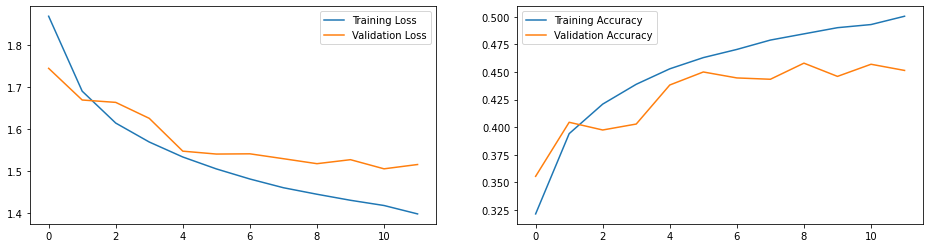

In [29]:
## Loss and acuracy
plot_history(history_1)

In [30]:
## Confusion matrix
pred_1= model_1.predict(x_test_norm)
pred_1=np.argmax(pred_1, axis=1)

313/313 [==============================] - 1s 1ms/step


313/313 [==============================] - 0s 1ms/step


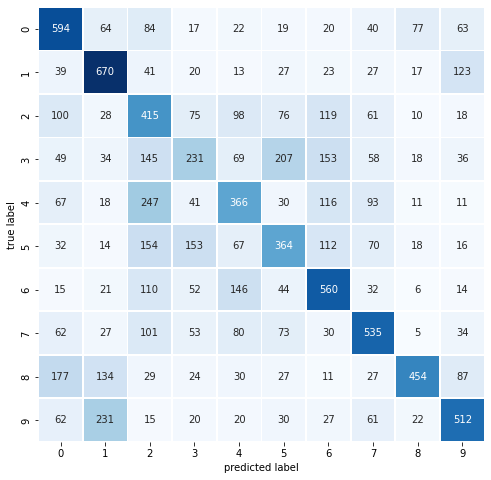

In [31]:
# Get the predicted classes:
pred_classes_1 = np.argmax(model_1.predict(x_test_norm), axis=-1)
pred_classes_1;

conf_mx_1 = tf.math.confusion_matrix(y_test, pred_classes_1)
conf_mx_1;

plot_confusion_matrix(y_test,pred_classes_1)

#### Activation and Performance

In [32]:
# Extracts the outputs of all layers:
layer_outputs_1 = [layer.output for layer in model_1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_1 = models.Model(inputs=model_1.input, outputs=layer_outputs_1)

# Get activation values for the last dense layer
activations_1 = activation_model_1.predict(x_valid_norm[:3250])
dense_layer_activations_1 = activations_1[-3]
output_layer_activations_1 = activations_1[-1]

102/102 [==============================] - 0s 1ms/step


In [33]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_1 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_1 = tsne_1.fit_transform(dense_layer_activations_1)

# Scaling
tsne_results_1 = (tsne_results_1 - tsne_results_1.min()) / (tsne_results_1.max() - tsne_results_1.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 4.747538
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.908745
[t-SNE] KL divergence after 300 iterations: 2.422719


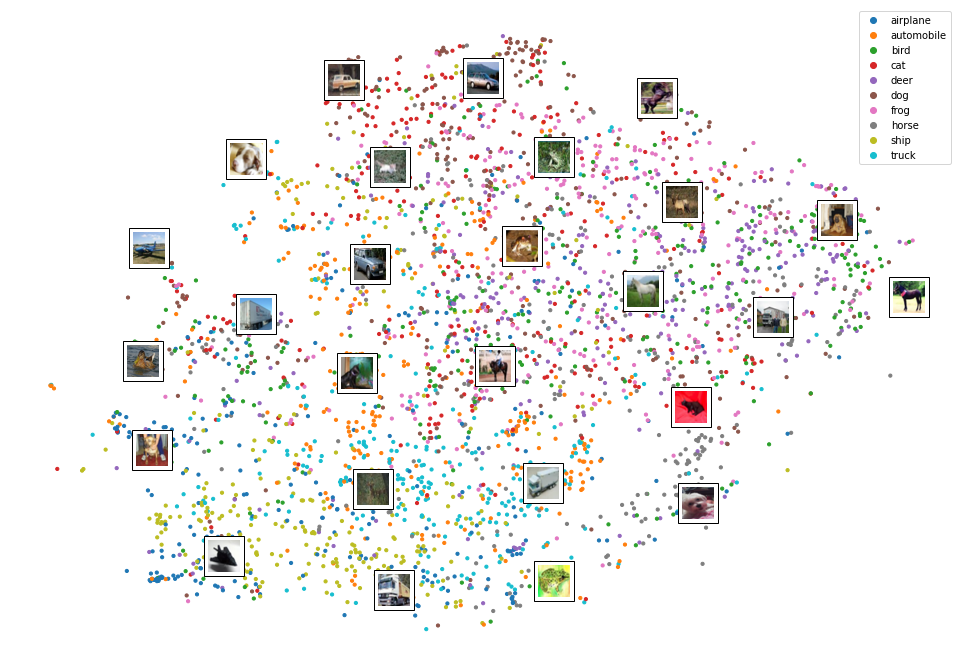

In [34]:
cmap_1 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_1 = plt.scatter(tsne_results_1[:,0],tsne_results_1[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_1)
plt.legend(handles=scatter_1.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_1):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##Experiment 2: DNN with 3 layers (no regularization)

Hidden layer 1: 100

Hidden layer 2: 150

Hidden layer 3: 75

Output layer: 10 (one for each image)

#### Build, Compile, Train, Evaluate

In [35]:
model_2 = Sequential()
model_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_2.add(layers.Dense(units = 100, activation = "relu"))
model_2.add(layers.Dense(units = 250, activation = "relu"))
model_2.add(layers.Dense(units = 150, activation = "relu"))
model_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               307300    
                                                                 
 dense_3 (Dense)             (None, 250)               25250     
                                                                 
 dense_4 (Dense)             (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


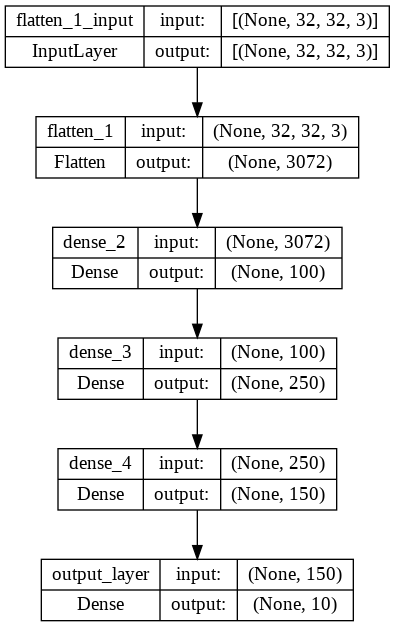

In [36]:
keras.utils.plot_model(model_2, "CIFAR_model.png", show_shapes=True) 

In [37]:
## Compile

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [38]:
## Train 

history_2 = model_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.8613 - accuracy: 0.3233 - val_loss: 1.7795 - val_accuracy: 0.3562
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6824 - accuracy: 0.3920 - val_loss: 1.6541 - val_accuracy: 0.3948
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6028 - accuracy: 0.4235 - val_loss: 1.6979 - val_accuracy: 0.3914
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5528 - accuracy: 0.4443 - val_loss: 1.5806 - val_accuracy: 0.4350
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5076 - accuracy: 0.4599 - val_loss: 1.6308 - val_accuracy: 0.4072
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4780 - accuracy: 0.4686 - val_loss: 1.5276 - val_accuracy: 0.4562
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4467 - accuracy: 0.4856 - val_loss: 1.5242 - val_accuracy: 0.4544

In [39]:
## Evaluate

model_2 = tf.keras.models.load_model("DNN_model_2.h5")
print(f"Test acc: {model_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4374 - accuracy: 0.5006
Test acc: 0.501


#### Plot Metrics

In [40]:
history_dict_2 = history_2.history
history_dict_2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
history_df_2=pd.DataFrame(history_dict_2)
history_df_2.tail().round(3)

loss  accuracy  val_loss  val_accuracy
16  1.252     0.552     1.493         0.480
17  1.238     0.558     1.466         0.492
18  1.222     0.563     1.622         0.447
19  1.203     0.567     1.469         0.492
20  1.189     0.574     1.511         0.475

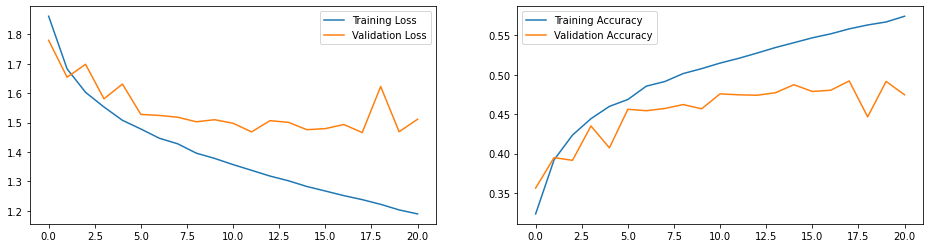

In [42]:
## Loss and acuracy
plot_history(history_2)

In [43]:
## Confusion matrix
pred_2= model_2.predict(x_test_norm)
pred_2=np.argmax(pred_2, axis=1)

313/313 [==============================] - 1s 1ms/step


313/313 [==============================] - 0s 2ms/step


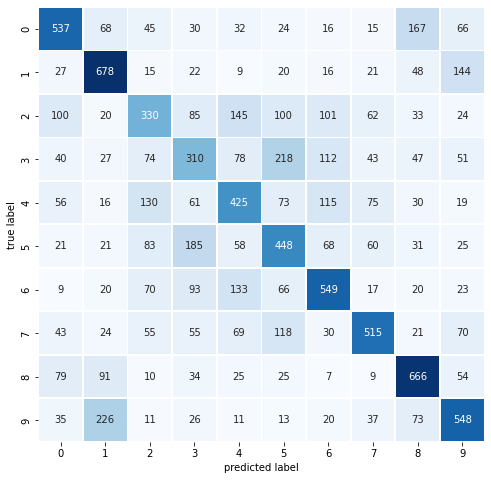

In [44]:
# Get the predicted classes:
pred_classes_2 = np.argmax(model_2.predict(x_test_norm), axis=-1)
pred_classes_2;

conf_mx_2 = tf.math.confusion_matrix(y_test, pred_classes_2)
conf_mx_2;

plot_confusion_matrix(y_test,pred_classes_2)

#### Activation and Performance

In [45]:
# Extracts the outputs of all layers:
layer_outputs_2 = [layer.output for layer in model_2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_2 = models.Model(inputs=model_2.input, outputs=layer_outputs_2)

# Get activation values for the last dense layer
activations_2 = activation_model_2.predict(x_valid_norm[:3250])
dense_layer_activations_2 = activations_2[-3]
output_layer_activations_2 = activations_2[-1]

102/102 [==============================] - 0s 1ms/step


In [46]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_2 = tsne_2.fit_transform(dense_layer_activations_2)

# Scaling
tsne_results_2 = (tsne_results_2 - tsne_results_2.min()) / (tsne_results_2.max() - tsne_results_2.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 3.894334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.871521
[t-SNE] KL divergence after 300 iterations: 2.403088


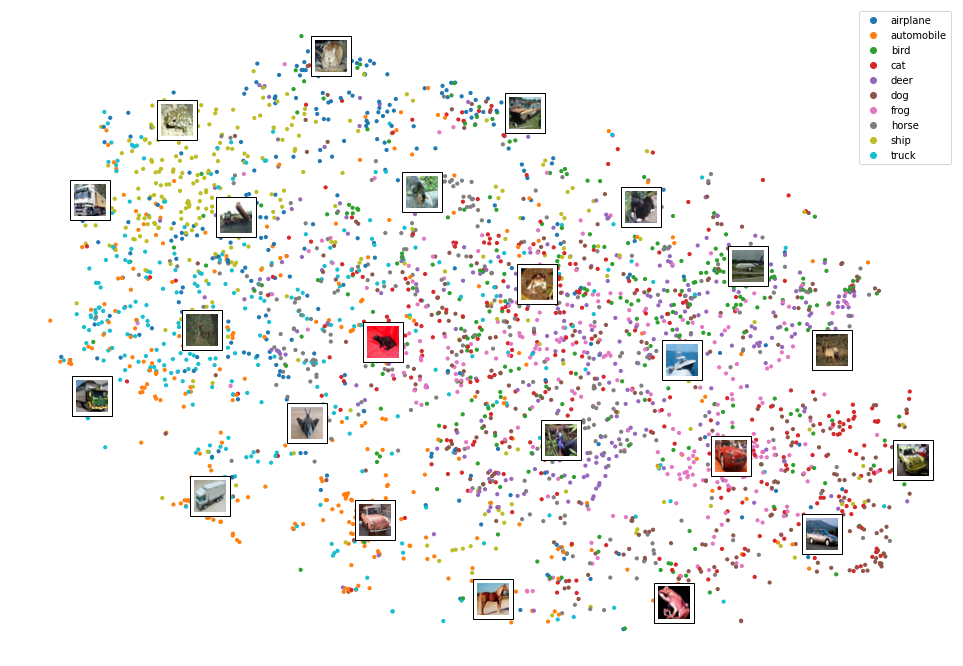

In [47]:
cmap_2 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_2 = plt.scatter(tsne_results_2[:,0],tsne_results_2[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_2)
plt.legend(handles=scatter_2.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_2):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer: 384

#### Build, Compile, Train, Evaluate

In [48]:
## Build CNN

model_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 384)              

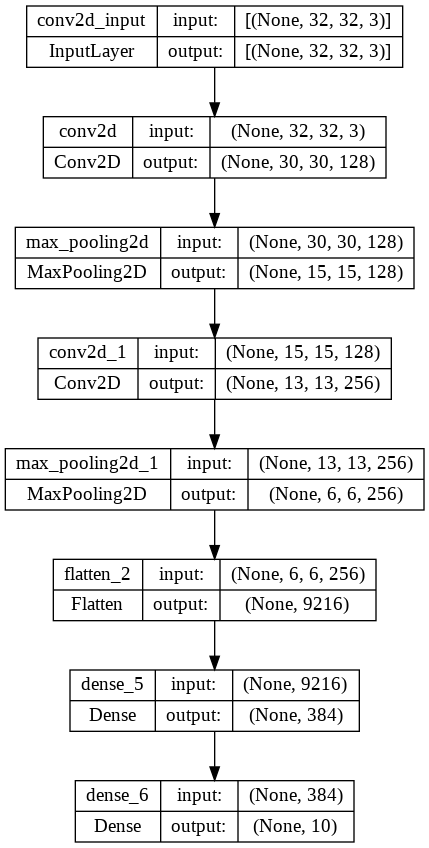

In [49]:
keras.utils.plot_model(model_3, "CIFAR10.png", show_shapes=True) 

In [50]:
## Compile

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [51]:
## Train 

history_3 = model_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 12s 10ms/step - loss: 2.1692 - accuracy: 0.1721 - val_loss: 2.0476 - val_accuracy: 0.1804
Epoch 2/200
704/704 [==============================] - 7s 10ms/step - loss: 2.0010 - accuracy: 0.1836 - val_loss: 1.9542 - val_accuracy: 0.1848
Epoch 3/200
704/704 [==============================] - 7s 10ms/step - loss: 1.9340 - accuracy: 0.1952 - val_loss: 1.9264 - val_accuracy: 0.2080
Epoch 4/200
704/704 [==============================] - 7s 10ms/step - loss: 1.8684 - accuracy: 0.2493 - val_loss: 1.8081 - val_accuracy: 0.2712
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7696 - accuracy: 0.2866 - val_loss: 1.7386 - val_accuracy: 0.2894
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7058 - accuracy: 0.3016 - val_loss: 1.6893 - val_accuracy: 0.2942
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6606 - accuracy: 0.3169 - val_loss: 1.6721 - val_accuracy

In [52]:
## Evaluate

model_3 = tf.keras.models.load_model("CNN_model_3.h5")
print(f"Test acc: {model_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.1509 - accuracy: 0.6781
Test acc: 0.678


#### Plot Metrics

In [53]:
history_dict_3 = history_3.history
history_dict_3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
history_df_3=pd.DataFrame(history_dict_3)
history_df_3.tail().round(3)

loss  accuracy  val_loss  val_accuracy
39  0.576     0.839     1.169         0.669
40  0.563     0.843     1.133         0.693
41  0.547     0.850     1.166         0.679
42  0.541     0.851     1.196         0.677
43  0.537     0.853     1.191         0.678

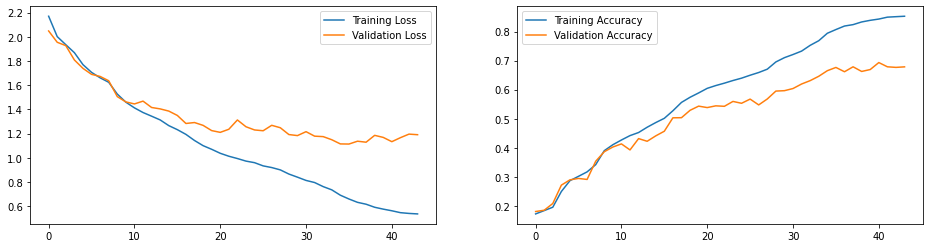

In [55]:
## Loss and acuracy
plot_history(history_3)

In [56]:
## Confusion matrix
pred_3= model_3.predict(x_test_norm)
pred_3=np.argmax(pred_3, axis=1)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


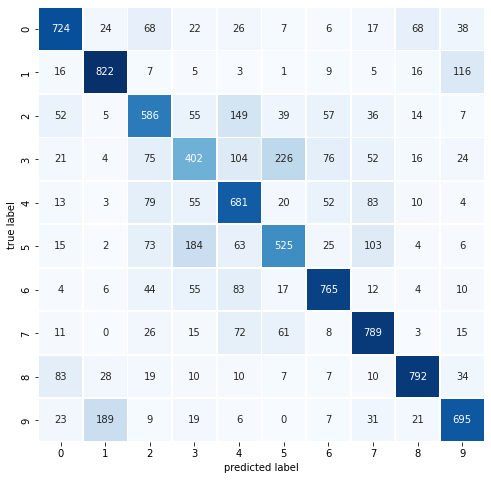

In [57]:
# Get the predicted classes:
pred_classes_3 = np.argmax(model_3.predict(x_test_norm), axis=-1)
pred_classes_3;

conf_mx_3 = tf.math.confusion_matrix(y_test, pred_classes_3)
conf_mx_3;

plot_confusion_matrix(y_test,pred_classes_3)

#### Activation and Performance

In [58]:
# Extracts the outputs of all layers:
layer_outputs_3 = [layer.output for layer in model_3.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_3 = models.Model(inputs=model_3.input, outputs=layer_outputs_3)

# Get activation values for the last dense layer
activations_3 = activation_model_3.predict(x_valid_norm[:3250])
dense_layer_activations_3 = activations_3[-3]
output_layer_activations_3 = activations_3[-1]

102/102 [==============================] - 0s 2ms/step


In [59]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_3 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_3 = tsne_3.fit_transform(dense_layer_activations_3)

# Scaling
tsne_results_3 = (tsne_results_3 - tsne_results_3.min()) / (tsne_results_3.max() - tsne_results_3.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.022s...
[t-SNE] Computed neighbors for 3250 samples in 1.850s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 4.445059
[t-SNE] KL divergence after 250 iterations with early exaggeration: 136.574432
[t-SNE] KL divergence after 300 iterations: 4.975550


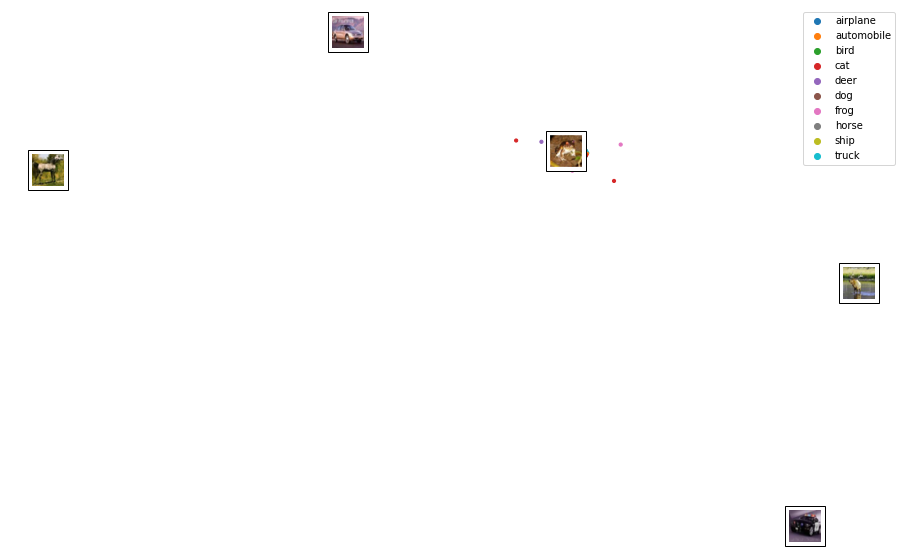

In [60]:
cmap_3 = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter_3 = plt.scatter(tsne_results_3[:,0],tsne_results_3[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_3)
plt.legend(handles=scatter_3.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_3):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Predictions

In [62]:
model_3 = tf.keras.models.load_model('CNN_model_3.h5')
preds_3 = model_3.predict(x_test_norm)
preds_3.shape

313/313 [==============================] - 1s 3ms/step


(10000, 10)

In [63]:
cm_3 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [64]:
df_3 = pd.DataFrame(preds_3[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_3.style.format("{:.2%}").background_gradient(cmap=cm_3)

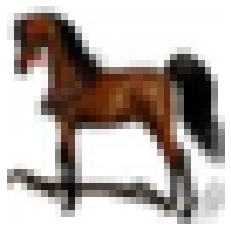

In [65]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_3 = test_images[2004]
img_tensor_3 = image.img_to_array(img_3)
img_tensor_3 = np.expand_dims(img_tensor_3, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_3, cmap='viridis')
plt.axis('off')
plt.show()

In [66]:
# Extracts the outputs of the top 8 layers:
layer_outputs_3 = [layer.output for layer in model_3.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_3 = models.Model(inputs=model_3.input, outputs=layer_outputs_3)

In [67]:
activations_3 = activation_model_3.predict(img_tensor_3)
len(activations_3)

1/1 [==============================] - 0s 141ms/step


7

In [68]:
layer_names = []
for layer in model_3.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten_2',
 'dense_5',
 'dense_6']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


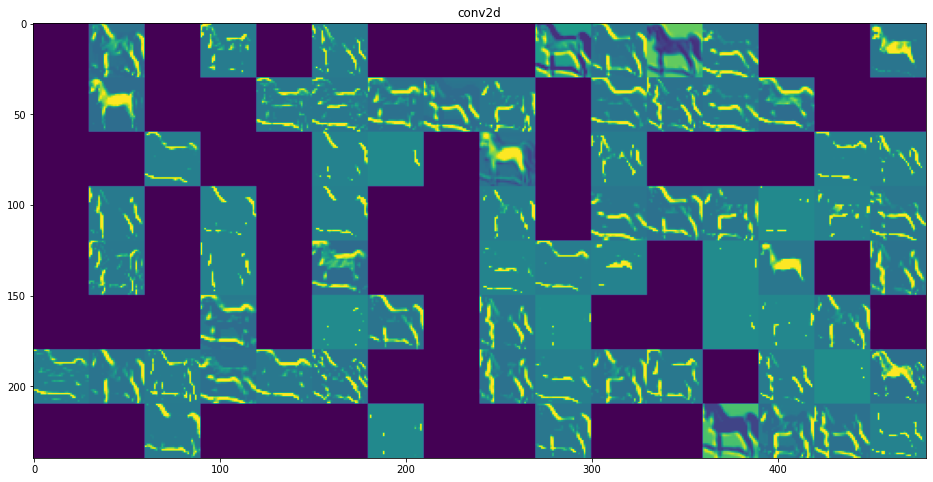

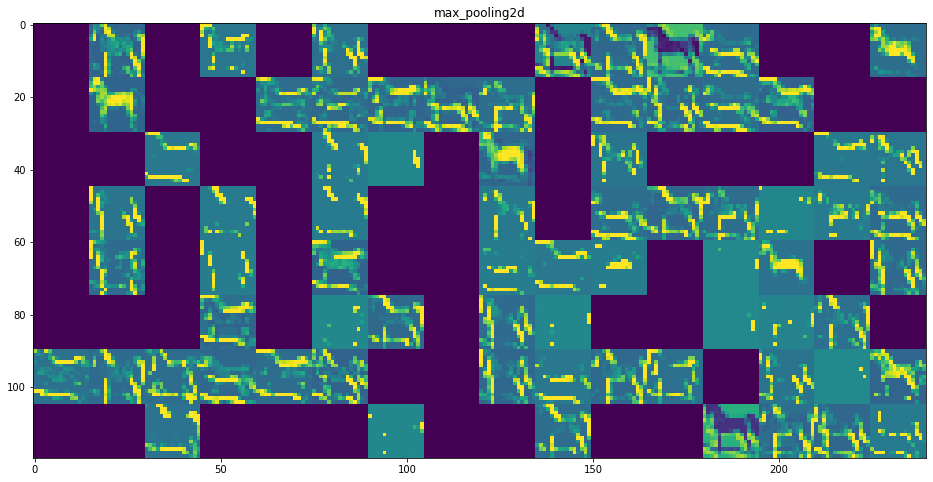

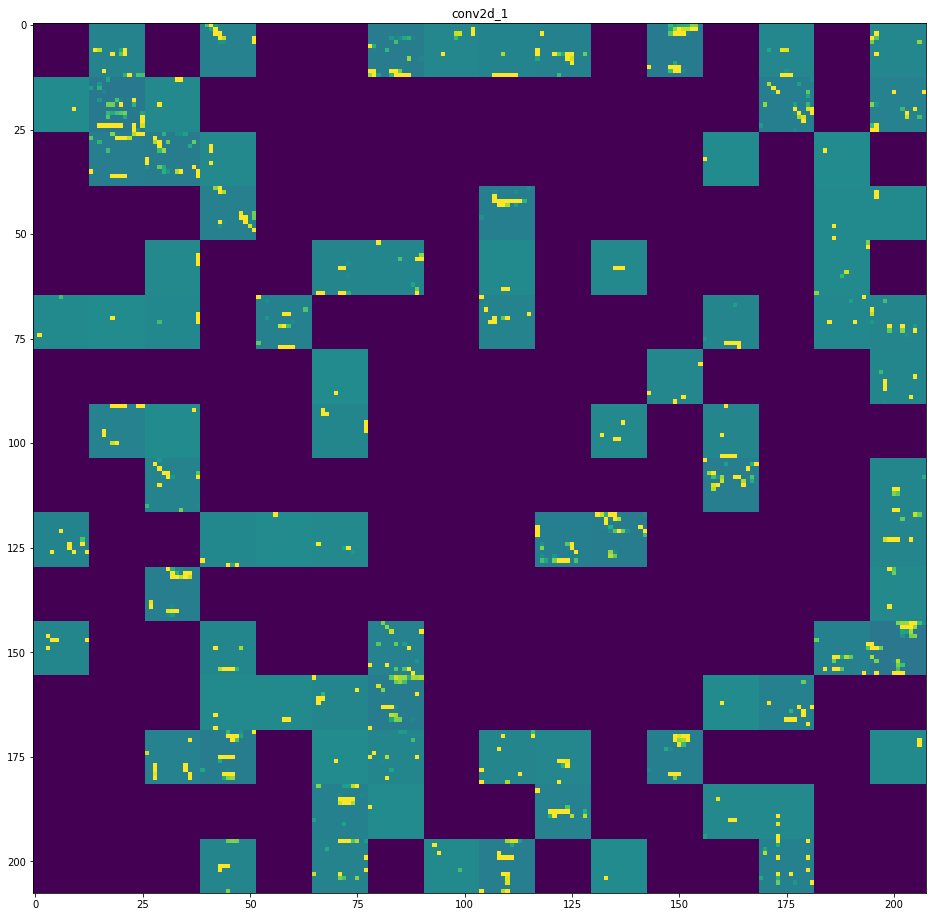

In [69]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_3.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_3):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Experiment 4: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer 3: 512

Layer: 384

#### Build, Compile, Train, Evaluate

In [70]:
## Build CNN

model_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), #Start of Layer 1
  MaxPool2D((2, 2),strides=2), #End of Layer 1
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 2
  MaxPool2D((2, 2),strides=2), #End of Layer 2
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 3
  MaxPool2D((2, 2),strides=2), #End of Layer 3
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification
  BatchNormalization(),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

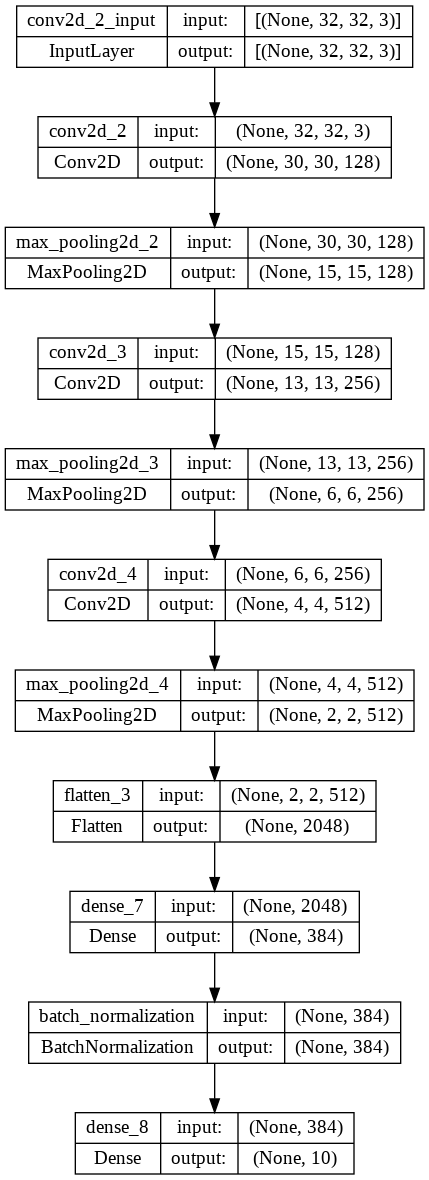

In [71]:
keras.utils.plot_model(model_4, "CIFAR10.png", show_shapes=True) 

In [72]:
## Compile
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [73]:
## Train
history_4 = model_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 9s 12ms/step - loss: 1.5071 - accuracy: 0.4727 - val_loss: 1.4393 - val_accuracy: 0.4938
Epoch 2/200
704/704 [==============================] - 8s 12ms/step - loss: 1.0855 - accuracy: 0.6372 - val_loss: 1.0787 - val_accuracy: 0.6414
Epoch 3/200
704/704 [==============================] - 8s 12ms/step - loss: 0.8979 - accuracy: 0.7089 - val_loss: 0.9196 - val_accuracy: 0.7016
Epoch 4/200
704/704 [==============================] - 8s 12ms/step - loss: 0.7773 - accuracy: 0.7524 - val_loss: 0.8772 - val_accuracy: 0.7232
Epoch 5/200
704/704 [==============================] - 8s 11ms/step - loss: 0.6626 - accuracy: 0.7954 - val_loss: 0.9077 - val_accuracy: 0.7246
Epoch 6/200
704/704 [==============================] - 8s 11ms/step - loss: 0.5764 - accuracy: 0.8258 - val_loss: 0.9390 - val_accuracy: 0.7146
Epoch 7/200
704/704 [==============================] - 8s 11ms/step - loss: 0.4964 - accuracy: 0.8546 - val_loss: 0.9056 - val_accuracy:

In [74]:
## Evalute

model_4 = tf.keras.models.load_model("CNN_model_4.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8871 - accuracy: 0.7229
Test acc: 0.723


#### Plot Metrics

In [75]:
history_dict_4 = history_4.history
history_dict_4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [76]:
history_df_4=pd.DataFrame(history_dict_4)
history_df_4.tail().round(3)

loss  accuracy  val_loss  val_accuracy
6   0.496     0.855     0.906         0.731
7   0.428     0.879     0.958         0.744
8   0.367     0.901     1.040         0.728
9   0.327     0.916     1.138         0.733
10  0.283     0.931     1.241         0.726

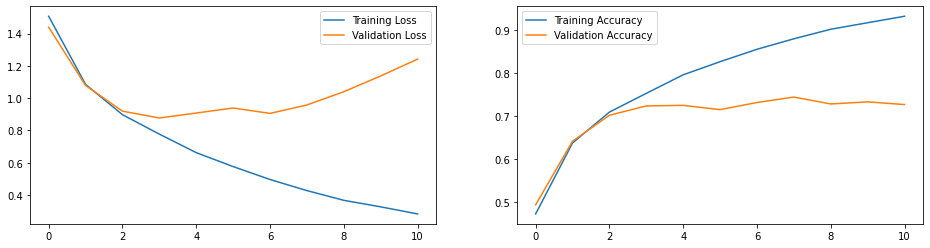

In [77]:
## Loss and acuracy
plot_history(history_4)

In [78]:
## Confusion matrix
pred_4= model_4.predict(x_test_norm)
pred_4=np.argmax(pred_4, axis=1)

313/313 [==============================] - 1s 3ms/step


313/313 [==============================] - 1s 3ms/step


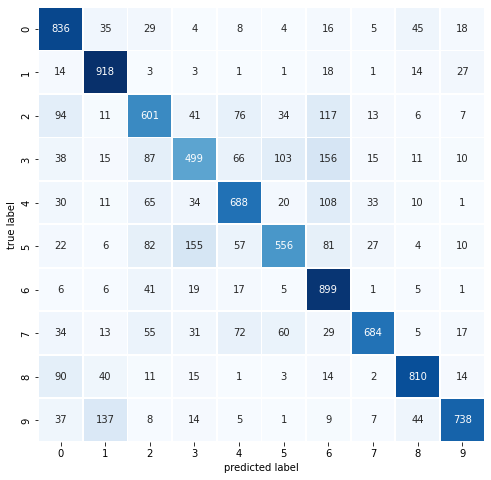

In [79]:
# Get the predicted classes:
pred_classes_4 = np.argmax(model_4.predict(x_test_norm), axis=-1)
pred_classes_4;

conf_mx_4 = tf.math.confusion_matrix(y_test, pred_classes_4)
conf_mx_4;

plot_confusion_matrix(y_test,pred_classes_4)

#### Activation and Performance

In [80]:
# Extracts the outputs of all layers:
layer_outputs_4 = [layer.output for layer in model_4.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_4 = models.Model(inputs=model_4.input, outputs=layer_outputs_4)

# Get activation values for the last dense layer
activations_4 = activation_model_4.predict(x_valid_norm[:3250])
dense_layer_activations_4 = activations_4[-3]
output_layer_activations_4 = activations_4[-1]

102/102 [==============================] - 0s 3ms/step


In [81]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_4 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_4 = tsne_3.fit_transform(dense_layer_activations_4)

# Scaling
tsne_results_3 = (tsne_results_3 - tsne_results_3.min()) / (tsne_results_3.max() - tsne_results_3.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...
[t-SNE] Computed neighbors for 3250 samples in 0.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 0.057520
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.296997
[t-SNE] KL divergence after 300 iterations: 1.771710


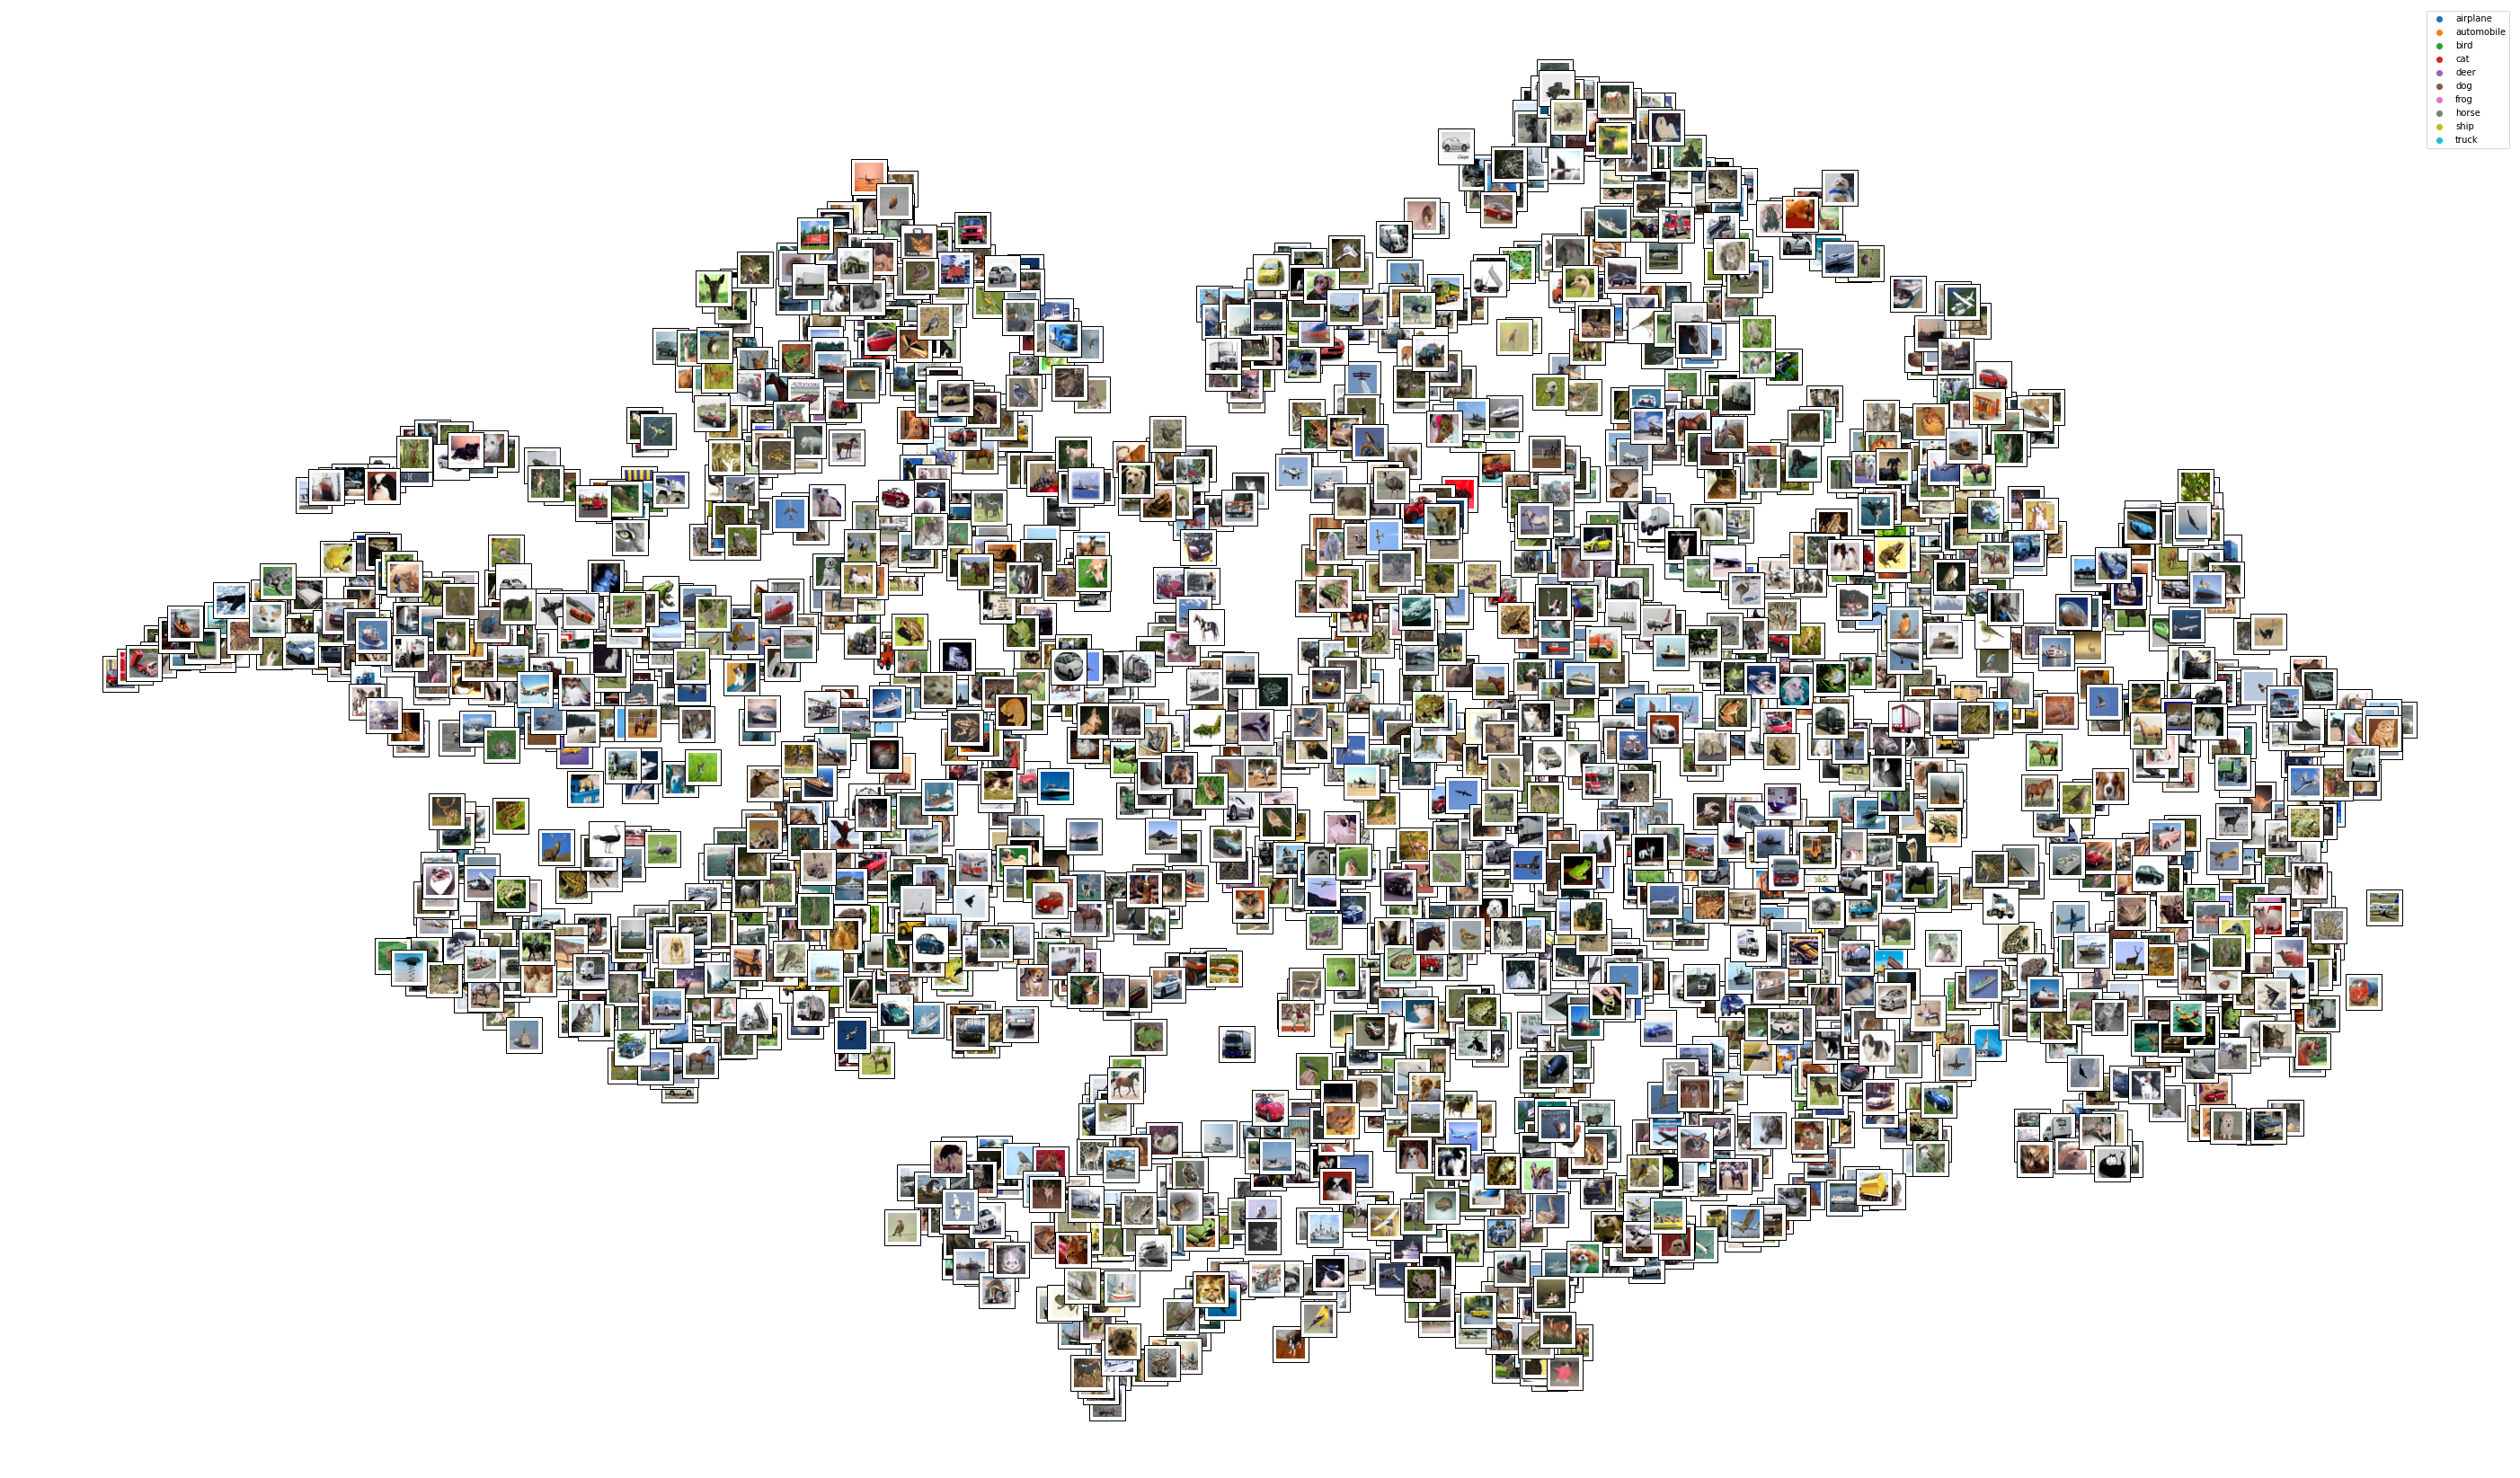

In [82]:
cmap_4 = plt.cm.tab10
plt.figure(figsize=(50,30))
scatter_4 = plt.scatter(tsne_results_4[:,0],tsne_results_4[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_4)
plt.legend(handles=scatter_4.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_4):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Predictions

In [84]:
model_4 = tf.keras.models.load_model('CNN_model_4.h5')
preds_4 = model_4.predict(x_test_norm)
preds_4.shape

313/313 [==============================] - 1s 3ms/step


(10000, 10)

In [85]:
cm_4 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [86]:
df_4= pd.DataFrame(preds_4[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_4.style.format("{:.2%}").background_gradient(cmap=cm_4)

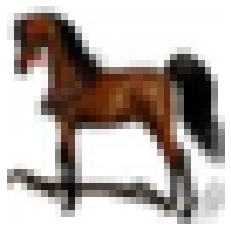

In [87]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_4 = test_images[2004]
img_tensor_4 = image.img_to_array(img_4)
img_tensor_4 = np.expand_dims(img_tensor_4, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_4, cmap='viridis')
plt.axis('off')
plt.show()

In [88]:
# Extracts the outputs of the top 8 layers:
layer_outputs_4 = [layer.output for layer in model_4.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_4 = models.Model(inputs=model_4.input, outputs=layer_outputs_4)

In [89]:
activations_4 = activation_model_4.predict(img_tensor_4)
len(activations_4)

1/1 [==============================] - 0s 110ms/step


8

In [90]:
layer_names = []
for layer in model_4.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'conv2d_4',
 'max_pooling2d_4',
 'flatten_3',
 'dense_7',
 'batch_normalization',
 'dense_8']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


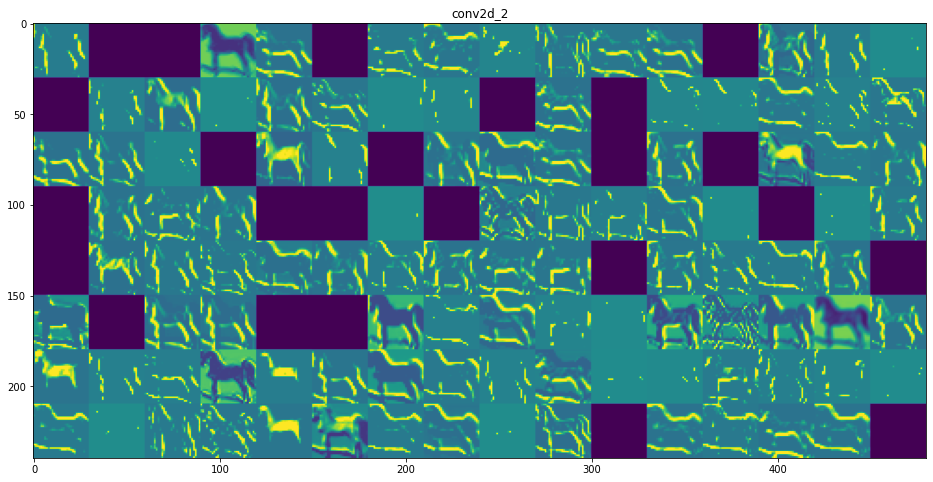

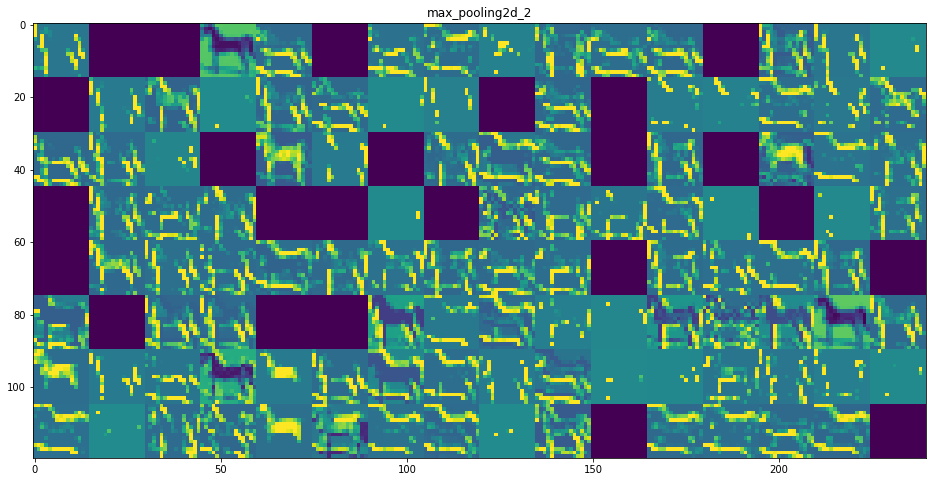

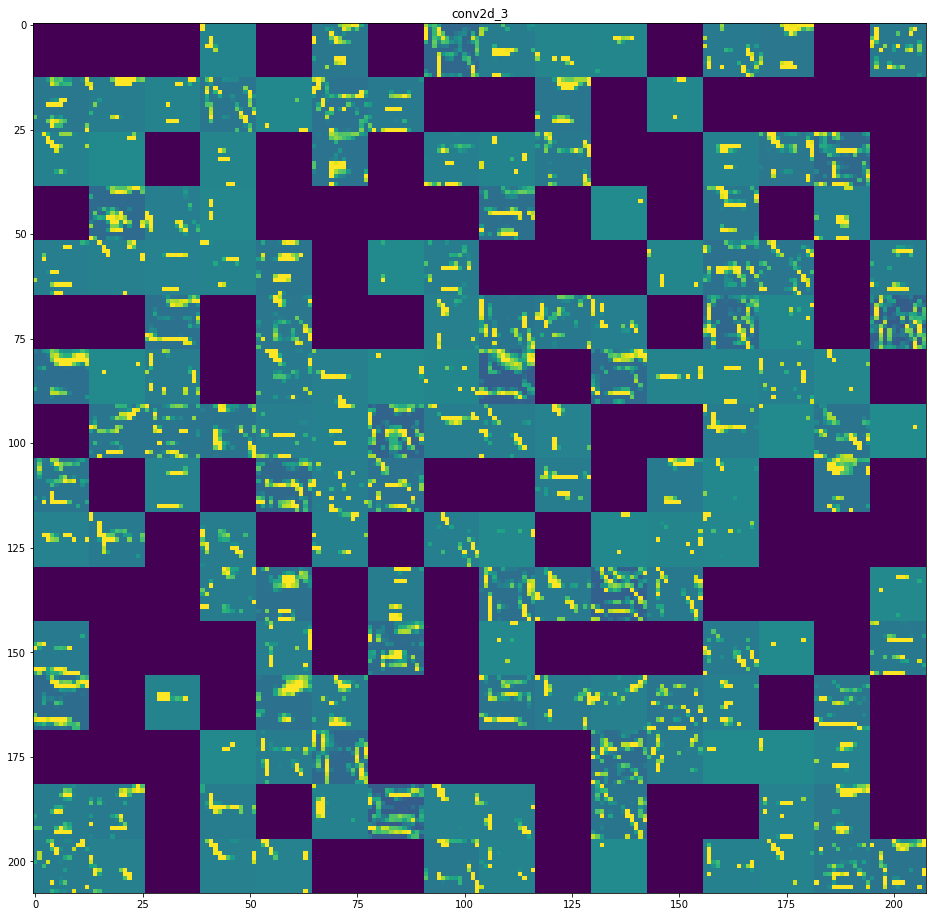

In [91]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_4.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_4):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Experiment 5: Experiments 1-4 with regularization 
https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

#### Model 5.1

Same as Model 1 with regularization - Dropout (0.25)

In [92]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_1 = Sequential()
model_5_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_1.add(layers.Dense(units = 100, activation = "relu"))
model_5_1.add(Dropout(0.25))
model_5_1.add(layers.Dense(units = 150, activation = "relu"))
model_5_1.add(Dropout(0.25))
model_5_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 100)               307300    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 150)               15150     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-tr

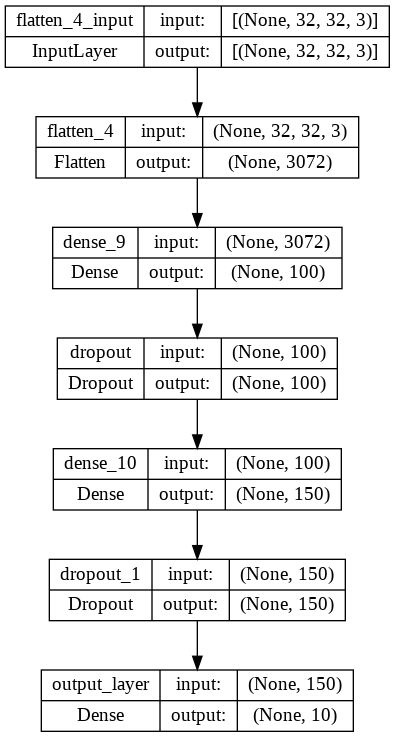

In [93]:
keras.utils.plot_model(model_5_1, "CIFAR_model.png", show_shapes=True) 

In [94]:
## Compile

model_5_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [95]:
## Train 

history_5_1 = model_5_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 2.0785 - accuracy: 0.2128 - val_loss: 1.9860 - val_accuracy: 0.2520
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9933 - accuracy: 0.2496 - val_loss: 1.9226 - val_accuracy: 0.2958
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9589 - accuracy: 0.2697 - val_loss: 1.8481 - val_accuracy: 0.3222
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9239 - accuracy: 0.2907 - val_loss: 1.8464 - val_accuracy: 0.3340
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8959 - accuracy: 0.3005 - val_loss: 1.8649 - val_accuracy: 0.3242
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8858 - accuracy: 0.3072 - val_loss: 1.8515 - val_accuracy: 0.3286
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8798 - accuracy: 0.3087 - val_loss: 1.8300 - val_accuracy: 0.3504

In [96]:
## Evaluate

model_5_1 = tf.keras.models.load_model("DNN_model_5_1.h5")
print(f"Test acc: {model_5_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.7764 - accuracy: 0.3734
Test acc: 0.373


#### Model 5.1.1

Same as Model 1 with regularization - Dropout (0.1)

In [121]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_11 = Sequential()
model_5_11.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_11.add(layers.Dense(units = 100, activation = "relu"))
model_5_11.add(Dropout(0.1))
model_5_11.add(layers.Dense(units = 150, activation = "relu"))
model_5_11.add(Dropout(0.1))
model_5_11.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_11.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 3072)              0         
                                                                 
 dense_24 (Dense)            (None, 100)               307300    
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 150)               15150     
                                                                 
 dropout_15 (Dropout)        (None, 150)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-t

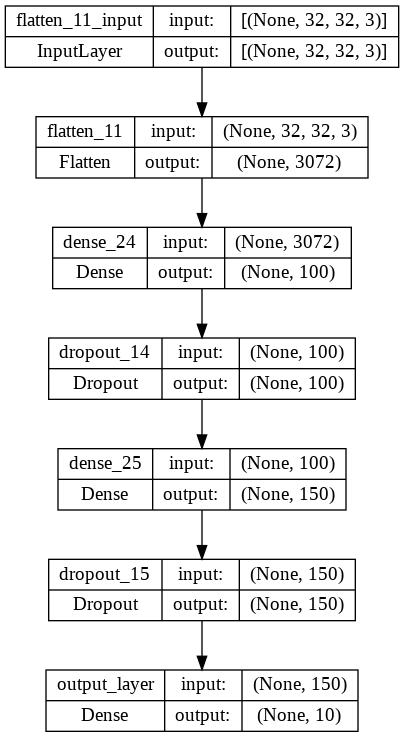

In [122]:
keras.utils.plot_model(model_5_11, "CIFAR_model.png", show_shapes=True) 

In [123]:
## Compile

model_5_11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [124]:
## Train 

history_5_11 = model_5_11.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_11.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.9568 - accuracy: 0.2802 - val_loss: 1.8729 - val_accuracy: 0.3268
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8332 - accuracy: 0.3295 - val_loss: 1.7727 - val_accuracy: 0.3616
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7954 - accuracy: 0.3471 - val_loss: 1.7324 - val_accuracy: 0.3696
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7636 - accuracy: 0.3602 - val_loss: 1.7055 - val_accuracy: 0.3876
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7379 - accuracy: 0.3669 - val_loss: 1.6870 - val_accuracy: 0.3964
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7222 - accuracy: 0.3757 - val_loss: 1.6895 - val_accuracy: 0.3878
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7133 - accuracy: 0.3791 - val_loss: 1.6926 - val_accuracy: 0.3822

In [125]:
## Evaluate

model_5_11 = tf.keras.models.load_model("DNN_model_5_11.h5")
print(f"Test acc: {model_5_11.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.6486 - accuracy: 0.4080
Test acc: 0.408


#### Model 5.1.2

Same as Model 5.1 with regularization - Dropout (0.1) new hidden nodes (550, 300)

In [179]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_12 = Sequential()
model_5_12.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_12.add(layers.Dense(units = 550, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(units = 300, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_12.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 3072)              0         
                                                                 
 dense_71 (Dense)            (None, 550)               1690150   
                                                                 
 dropout_41 (Dropout)        (None, 550)               0         
                                                                 
 dense_72 (Dense)            (None, 300)               165300    
                                                                 
 dropout_42 (Dropout)        (None, 300)               0         
                                                                 
 output_layer (Dense)        (None, 10)                3010      
                                                                 
Total params: 1,858,460
Trainable params: 1,858,460
N

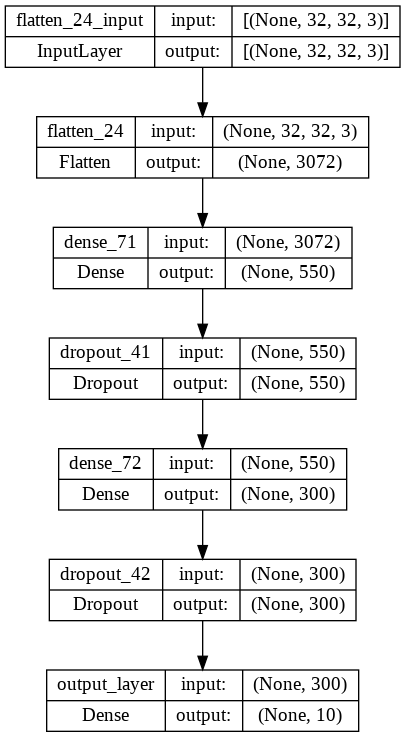

In [180]:
keras.utils.plot_model(model_5_12, "CIFAR_model.png", show_shapes=True) 

In [181]:
## Compile

model_5_12.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [182]:
## Train 

history_5_12 = model_5_12.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_12.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.9358 - accuracy: 0.3032 - val_loss: 1.7884 - val_accuracy: 0.3556
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7533 - accuracy: 0.3708 - val_loss: 1.7094 - val_accuracy: 0.4060
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6992 - accuracy: 0.3928 - val_loss: 1.6770 - val_accuracy: 0.4034
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6498 - accuracy: 0.4088 - val_loss: 1.6248 - val_accuracy: 0.4158
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6085 - accuracy: 0.4226 - val_loss: 1.6224 - val_accuracy: 0.4168
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5875 - accuracy: 0.4323 - val_loss: 1.5648 - val_accuracy: 0.4284
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5572 - accuracy: 0.4440 - val_loss: 1.5511 - val_accuracy: 0.4440

In [183]:
## Evaluate

model_5_12 = tf.keras.models.load_model("DNN_model_5_12.h5")
print(f"Test acc: {model_5_12.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4695 - accuracy: 0.4767
Test acc: 0.477


#### Model 5.1.3

Same as Model 5.1.2 with regularization - Dropout (0.10) + added layer (250 nodes) + output activation = sigmoid

In [193]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_12 = Sequential()
model_5_12.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_12.add(layers.Dense(units = 550, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(units = 300, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(units = 250, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_12.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 3072)              0         
                                                                 
 dense_80 (Dense)            (None, 550)               1690150   
                                                                 
 dropout_50 (Dropout)        (None, 550)               0         
                                                                 
 dense_81 (Dense)            (None, 300)               165300    
                                                                 
 dropout_51 (Dropout)        (None, 300)               0         
                                                                 
 dense_82 (Dense)            (None, 250)               75250     
                                                                 
 dropout_52 (Dropout)        (None, 250)             

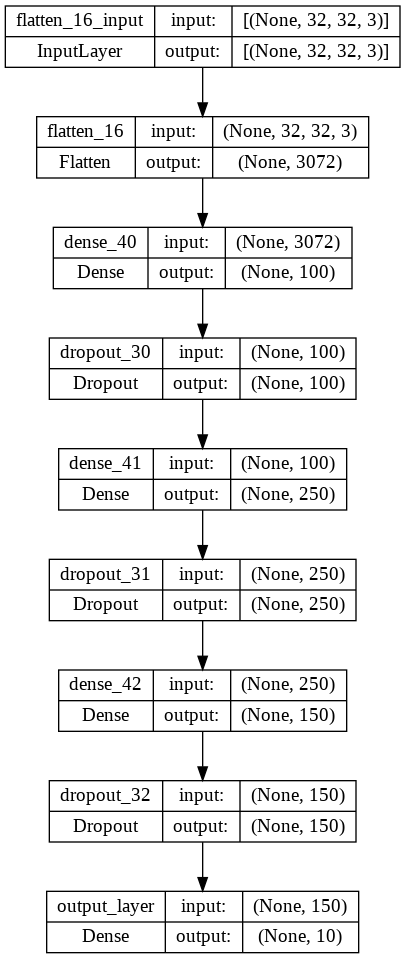

In [194]:
keras.utils.plot_model(model_5_13, "CIFAR_model.png", show_shapes=True) 

In [195]:
## Compile

model_5_13.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [196]:
## Train 

history_5_13 = model_5_13.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_13.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5326 - accuracy: 0.4499 - val_loss: 1.5443 - val_accuracy: 0.4464
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5284 - accuracy: 0.4498 - val_loss: 1.5453 - val_accuracy: 0.4502
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5270 - accuracy: 0.4504 - val_loss: 1.5270 - val_accuracy: 0.4560
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5243 - accuracy: 0.4514 - val_loss: 1.5980 - val_accuracy: 0.4358
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5193 - accuracy: 0.4508 - val_loss: 1.5344 - val_accuracy: 0.4458
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5156 - accuracy: 0.4553 - val_loss: 1.5441 - val_accuracy: 0.4454


In [197]:
## Evaluate

model_5_13 = tf.keras.models.load_model("DNN_model_5_13.h5")
print(f"Test acc: {model_5_13.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.5220 - accuracy: 0.4570
Test acc: 0.457


#### Model 5.2 

Same as Model 2 with regularization

In [97]:
model_5_2 = Sequential()
model_5_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_2.add(layers.Dense(units = 100, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 250, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 150, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_11 (Dense)            (None, 100)               307300    
                                                                 
 dense_12 (Dense)            (None, 250)               25250     
                                                                 
 dense_13 (Dense)            (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


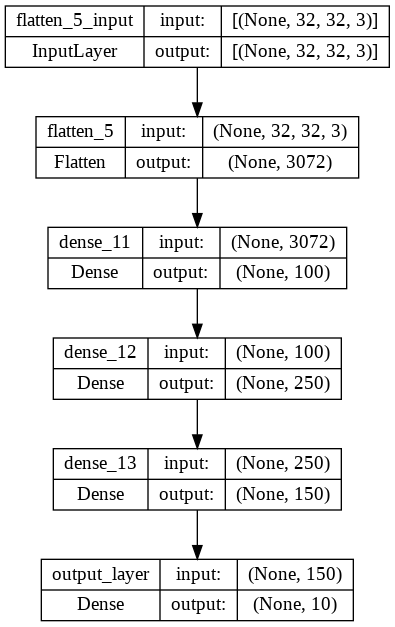

In [98]:
keras.utils.plot_model(model_5_2, "CIFAR_model.png", show_shapes=True) 

In [99]:
## Compile

model_5_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [100]:
## Train 

history_5_2 = model_5_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 2.5409 - accuracy: 0.2910 - val_loss: 2.0692 - val_accuracy: 0.3068
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9903 - accuracy: 0.3370 - val_loss: 2.1348 - val_accuracy: 0.2772
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9445 - accuracy: 0.3446 - val_loss: 1.9459 - val_accuracy: 0.3360
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9174 - accuracy: 0.3503 - val_loss: 1.9799 - val_accuracy: 0.3082
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9107 - accuracy: 0.3546 - val_loss: 1.8705 - val_accuracy: 0.3636
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8902 - accuracy: 0.3598 - val_loss: 1.9286 - val_accuracy: 0.3428
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8776 - accuracy: 0.3654 - val_loss: 1.8940 - val_accuracy: 0.3560

In [101]:
## Evaluate

model_5_2 = tf.keras.models.load_model("DNN_model_5_2.h5")
print(f"Test acc: {model_5_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.8442 - accuracy: 0.3815
Test acc: 0.382


#### Model 5.2.1

Same as Model 2 with bais regularization L2

In [200]:
from keras.regularizers import l2

model_5_21 = Sequential()
model_5_21.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_21.add(layers.Dense(units = 100, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 150, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_21.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 3072)              0         
                                                                 
 dense_86 (Dense)            (None, 100)               307300    
                                                                 
 dense_87 (Dense)            (None, 250)               25250     
                                                                 
 dense_88 (Dense)            (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


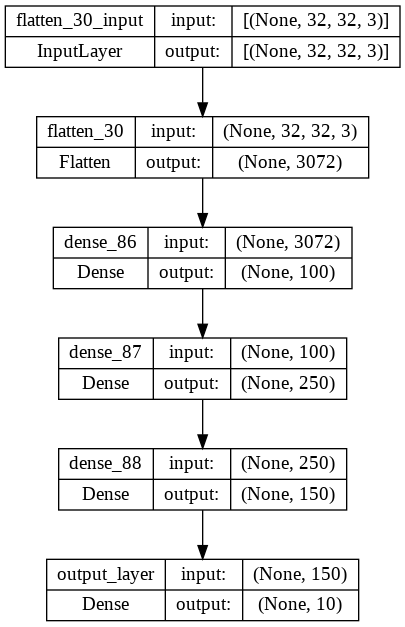

In [201]:
keras.utils.plot_model(model_5_21, "CIFAR_model.png", show_shapes=True) 

In [203]:
## Compile

model_5_21.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [204]:
## Train 

history_5_21 = model_5_21.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_21.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8570 - accuracy: 0.3239 - val_loss: 1.7842 - val_accuracy: 0.3518
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6997 - accuracy: 0.3926 - val_loss: 1.6754 - val_accuracy: 0.4012
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6287 - accuracy: 0.4155 - val_loss: 1.6915 - val_accuracy: 0.3980
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5818 - accuracy: 0.4343 - val_loss: 1.5818 - val_accuracy: 0.4298
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5393 - accuracy: 0.4492 - val_loss: 1.5996 - val_accuracy: 0.4256
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5062 - accuracy: 0.4628 - val_loss: 1.5873 - val_accuracy: 0.4280
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4819 - accuracy: 0.4711 - val_loss: 1.5738 - val_accuracy: 0.4286

In [205]:
## Evaluate

model_5_21 = tf.keras.models.load_model("DNN_model_5_21.h5")
print(f"Test acc: {model_5_21.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.5413 - accuracy: 0.4425
Test acc: 0.442


#### Model 5.2.2

Same as Model 5.2.1 with bais regularization L2, updated nodes (550, 300, 250)

In [208]:
from keras.regularizers import l2

model_5_22 = Sequential()
model_5_22.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_22.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_22.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_33 (Flatten)        (None, 3072)              0         
                                                                 
 dense_95 (Dense)            (None, 550)               1690150   
                                                                 
 dense_96 (Dense)            (None, 300)               165300    
                                                                 
 dense_97 (Dense)            (None, 250)               75250     
                                                                 
 output_layer (Dense)        (None, 10)                2510      
                                                                 
Total params: 1,933,210
Trainable params: 1,933,210
Non-trainable params: 0
_________________________________________________________________


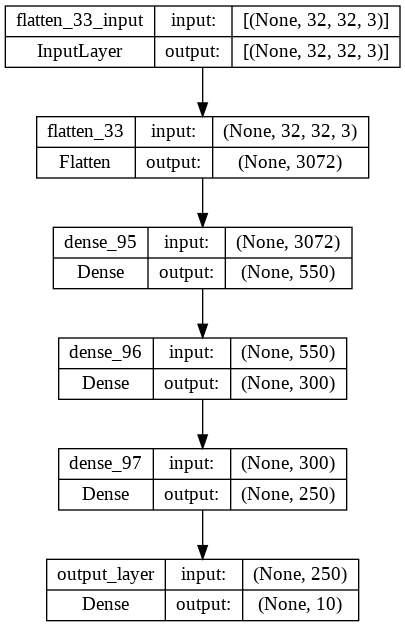

In [209]:
keras.utils.plot_model(model_5_22, "CIFAR_model.png", show_shapes=True) 

In [210]:
## Compile

model_5_22.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [211]:
## Train 

history_5_22 = model_5_22.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_22.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8997 - accuracy: 0.3120 - val_loss: 1.7812 - val_accuracy: 0.3460
Epoch 2/200
704/704 [==============================] - 2s 4ms/step - loss: 1.6843 - accuracy: 0.3957 - val_loss: 1.6523 - val_accuracy: 0.4088
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5955 - accuracy: 0.4307 - val_loss: 1.6031 - val_accuracy: 0.4190
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5375 - accuracy: 0.4501 - val_loss: 1.5575 - val_accuracy: 0.4412
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4926 - accuracy: 0.4650 - val_loss: 1.5227 - val_accuracy: 0.4526
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4597 - accuracy: 0.4808 - val_loss: 1.5442 - val_accuracy: 0.4460
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4286 - accuracy: 0.4886 - val_loss: 1.5199 - val_accuracy: 0.4524

In [212]:
## Evaluate

model_5_22 = tf.keras.models.load_model("DNN_model_5_22.h5")
print(f"Test acc: {model_5_22.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4508 - accuracy: 0.4913
Test acc: 0.491


#### Model 5.2.3

Same as Model 5.2.2 with dropout - 0.1 + output activation = sigmoid

In [219]:
from keras.regularizers import l2

model_5_23 = Sequential()
model_5_23.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_23.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_13.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_13.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_13.add(Dropout(0.1))
model_5_23.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_23.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_36 (Flatten)        (None, 3072)              0         
                                                                 
 dense_104 (Dense)           (None, 550)               1690150   
                                                                 
 dense_105 (Dense)           (None, 300)               165300    
                                                                 
 dense_106 (Dense)           (None, 250)               75250     
                                                                 
 output_layer (Dense)        (None, 10)                2510      
                                                                 
Total params: 1,933,210
Trainable params: 1,933,210
Non-trainable params: 0
_________________________________________________________________


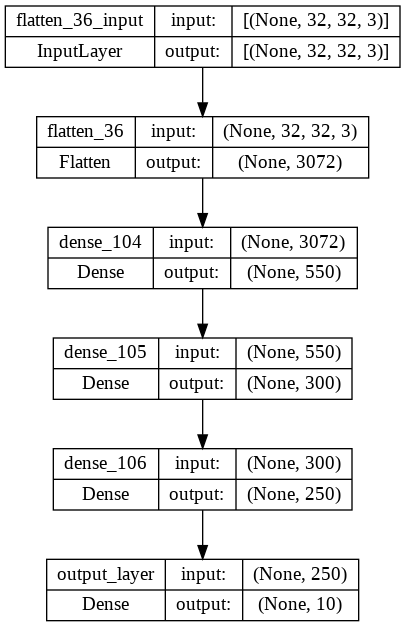

In [220]:
keras.utils.plot_model(model_5_23, "CIFAR_model.png", show_shapes=True) 

In [221]:
## Compile

model_5_23.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [222]:
## Train 

history_5_23 = model_5_23.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_23.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8733 - accuracy: 0.3222 - val_loss: 1.7414 - val_accuracy: 0.3666
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6770 - accuracy: 0.3998 - val_loss: 1.6739 - val_accuracy: 0.3908
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5971 - accuracy: 0.4306 - val_loss: 1.6585 - val_accuracy: 0.4114
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5373 - accuracy: 0.4515 - val_loss: 1.5610 - val_accuracy: 0.4398
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4947 - accuracy: 0.4660 - val_loss: 1.5390 - val_accuracy: 0.4520
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4557 - accuracy: 0.4819 - val_loss: 1.5511 - val_accuracy: 0.4412
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4282 - accuracy: 0.4888 - val_loss: 1.5203 - val_accuracy: 0.4558

In [223]:
## Evaluate

model_5_23 = tf.keras.models.load_model("DNN_model_5_23.h5")
print(f"Test acc: {model_5_23.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4531 - accuracy: 0.4891
Test acc: 0.489


In [ ]:
model_5_12.add(Dropout(0.1))

#### Model 5.3

Same as model 3 with regulaization

In [102]:
## Build CNN

model_5_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.3), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.3), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 256)        

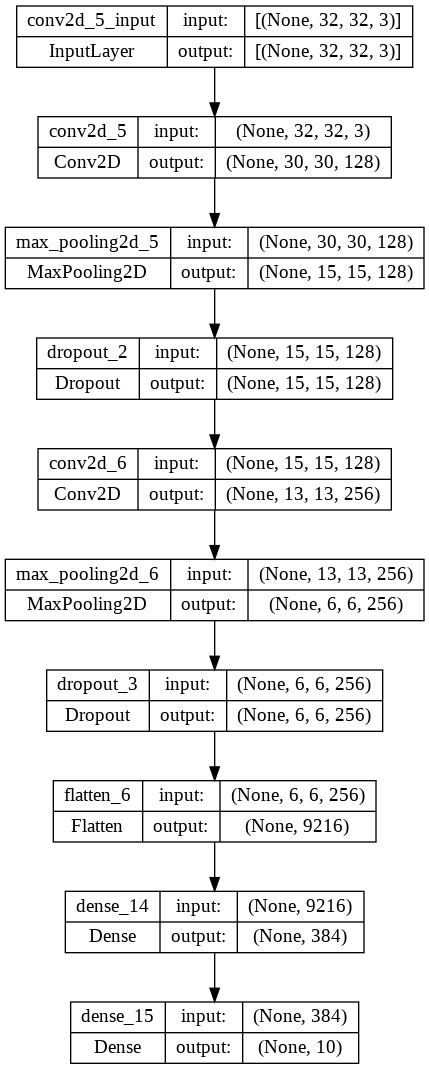

In [103]:
keras.utils.plot_model(model_5_3, "CIFAR10.png", show_shapes=True) 

In [104]:
## Compile

model_5_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [105]:
## Train 

history_5_3 = model_5_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 11ms/step - loss: 2.1608 - accuracy: 0.1729 - val_loss: 2.0588 - val_accuracy: 0.1730
Epoch 2/200
704/704 [==============================] - 7s 10ms/step - loss: 2.0034 - accuracy: 0.1867 - val_loss: 1.9581 - val_accuracy: 0.1976
Epoch 3/200
704/704 [==============================] - 7s 10ms/step - loss: 1.9276 - accuracy: 0.2282 - val_loss: 1.8914 - val_accuracy: 0.2422
Epoch 4/200
704/704 [==============================] - 8s 11ms/step - loss: 1.8366 - accuracy: 0.2648 - val_loss: 1.8231 - val_accuracy: 0.2564
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7694 - accuracy: 0.2800 - val_loss: 1.7369 - val_accuracy: 0.3072
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7174 - accuracy: 0.3074 - val_loss: 1.6815 - val_accuracy: 0.3066
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6519 - accuracy: 0.3340 - val_loss: 1.6212 - val_accuracy:

In [230]:
## Evaluate

model_5_3 = tf.keras.models.load_model("CNN_model_5_3.h5")
print(f"Test acc: {model_5_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.0499 - accuracy: 0.6641
Test acc: 0.664


#### Model 5.3.1

Same as model 5.3 + updated dropout (0.10)

In [224]:
## Build CNN

model_5_31 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_31.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_62 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_63 (Dropout)        (None, 6, 6, 256)       

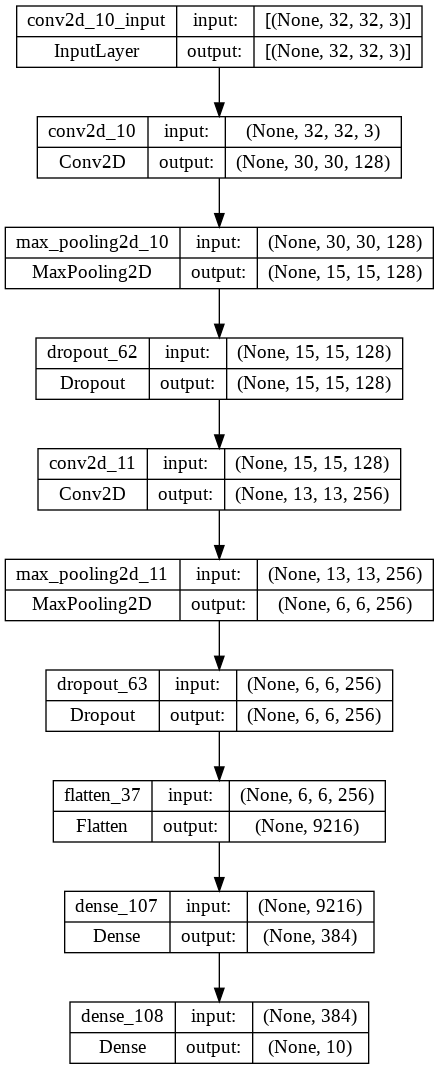

In [225]:
keras.utils.plot_model(model_5_31, "CIFAR10.png", show_shapes=True) 

In [226]:
## Compile

model_5_31.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [228]:
## Train 

history_5_31 = model_5_31.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_31.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 11ms/step - loss: 1.9405 - accuracy: 0.2477 - val_loss: 1.9193 - val_accuracy: 0.2438
Epoch 2/200
704/704 [==============================] - 8s 11ms/step - loss: 1.8301 - accuracy: 0.2643 - val_loss: 1.8183 - val_accuracy: 0.2694
Epoch 3/200
704/704 [==============================] - 8s 11ms/step - loss: 1.7597 - accuracy: 0.2780 - val_loss: 1.7991 - val_accuracy: 0.2794
Epoch 4/200
704/704 [==============================] - 8s 11ms/step - loss: 1.7117 - accuracy: 0.2913 - val_loss: 1.7930 - val_accuracy: 0.2934
Epoch 5/200
704/704 [==============================] - 7s 11ms/step - loss: 1.6774 - accuracy: 0.3014 - val_loss: 1.6760 - val_accuracy: 0.2986
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6318 - accuracy: 0.3334 - val_loss: 1.6363 - val_accuracy: 0.3418
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.5511 - accuracy: 0.3655 - val_loss: 1.5379 - val_accuracy:

In [231]:
## Evaluate

model_5_31 = tf.keras.models.load_model("CNN_model_5_31.h5")
print(f"Test acc: {model_5_31.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.0852 - accuracy: 0.6778
Test acc: 0.678


#### Model 5.3.2

Same as model 5.3.1 + updated nodes (250, 550, 250)

In [233]:
## Build CNN

model_5_32 = Sequential([
  Conv2D(filters=250, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 1 end
  Conv2D(filters=550, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 2 end
  Flatten(),
  Dense(units=250,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_32.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 250)       7000      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 250)      0         
 g2D)                                                            
                                                                 
 dropout_66 (Dropout)        (None, 15, 15, 250)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 550)       1238050   
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 550)        0         
 g2D)                                                            
                                                                 
 dropout_67 (Dropout)        (None, 6, 6, 550)       

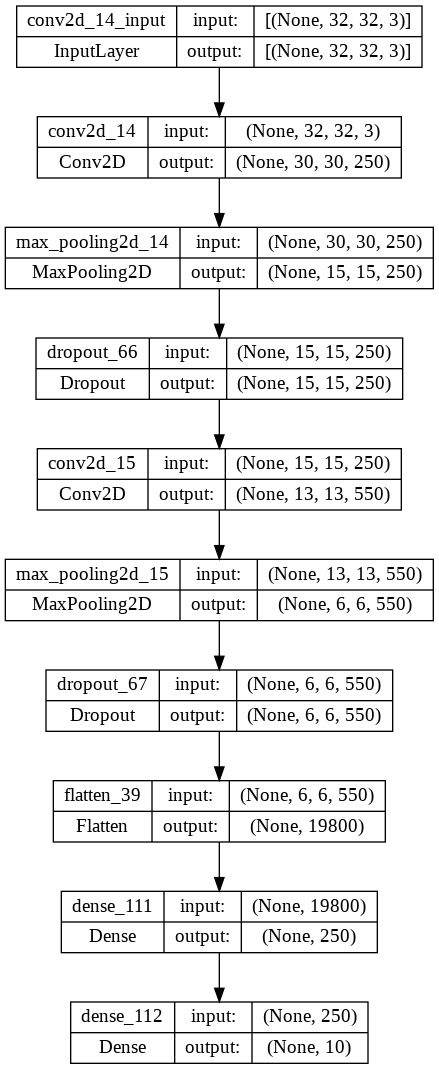

In [234]:
keras.utils.plot_model(model_5_32, "CIFAR10.png", show_shapes=True) 

In [236]:
## Compile

model_5_32.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [237]:
## Train 

history_5_32 = model_5_32.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_32.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 17s 23ms/step - loss: 2.1673 - accuracy: 0.1959 - val_loss: 2.0546 - val_accuracy: 0.1862
Epoch 2/200
704/704 [==============================] - 15s 22ms/step - loss: 1.9973 - accuracy: 0.2188 - val_loss: 1.9761 - val_accuracy: 0.2522
Epoch 3/200
704/704 [==============================] - 16s 22ms/step - loss: 1.9021 - accuracy: 0.2605 - val_loss: 1.8424 - val_accuracy: 0.3010
Epoch 4/200
704/704 [==============================] - 16s 22ms/step - loss: 1.7865 - accuracy: 0.3373 - val_loss: 1.7600 - val_accuracy: 0.3394
Epoch 5/200
704/704 [==============================] - 16s 23ms/step - loss: 1.6880 - accuracy: 0.3832 - val_loss: 1.6894 - val_accuracy: 0.3632
Epoch 6/200
704/704 [==============================] - 16s 22ms/step - loss: 1.6075 - accuracy: 0.4118 - val_loss: 1.5886 - val_accuracy: 0.4104
Epoch 7/200
704/704 [==============================] - 16s 22ms/step - loss: 1.5416 - accuracy: 0.4437 - val_loss: 1.5537 - val_ac

In [238]:
## Evaluate

model_5_32 = tf.keras.models.load_model("CNN_model_5_32.h5")
print(f"Test acc: {model_5_32.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.1009 - accuracy: 0.6571
Test acc: 0.657


#### Model 5.3.3

Same as model 5.3.1 + closeout activation = sigmoid

In [241]:
## Build CNN

model_5_33 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.sigmoid)       
])

model_5_33.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_73 (Dropout)        (None, 6, 6, 256)       

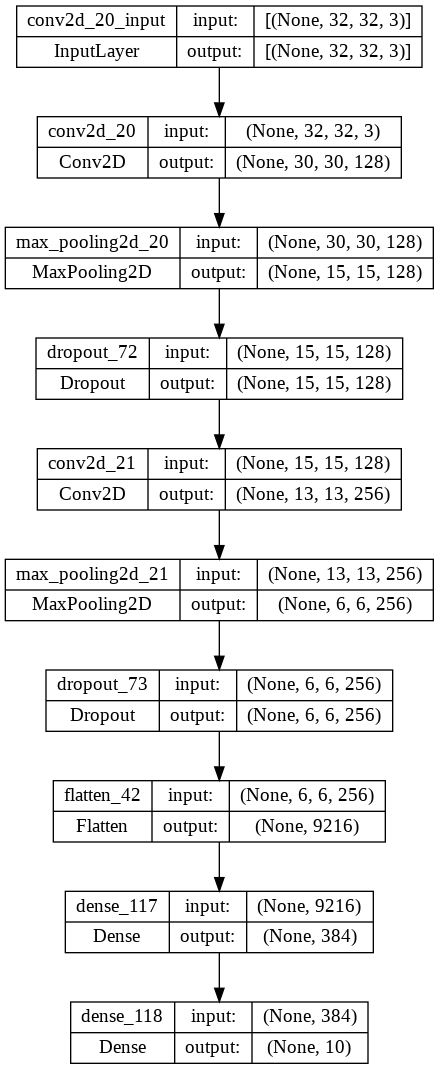

In [242]:
keras.utils.plot_model(model_5_33, "CIFAR10.png", show_shapes=True) 

In [243]:
## Compile

model_5_33.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [244]:
## Train 

history_5_33 = model_5_33.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_33.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 9s 11ms/step - loss: 2.2316 - accuracy: 0.1625 - val_loss: 2.1502 - val_accuracy: 0.1718
Epoch 2/200
704/704 [==============================] - 8s 11ms/step - loss: 2.0712 - accuracy: 0.1808 - val_loss: 2.0074 - val_accuracy: 0.1882
Epoch 3/200
704/704 [==============================] - 7s 11ms/step - loss: 1.9828 - accuracy: 0.1910 - val_loss: 1.9614 - val_accuracy: 0.1900
Epoch 4/200
704/704 [==============================] - 7s 10ms/step - loss: 1.9315 - accuracy: 0.2175 - val_loss: 1.8885 - val_accuracy: 0.2444
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 1.8642 - accuracy: 0.2607 - val_loss: 1.8426 - val_accuracy: 0.2622
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7969 - accuracy: 0.2837 - val_loss: 1.7744 - val_accuracy: 0.2720
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7442 - accuracy: 0.2978 - val_loss: 1.7449 - val_accuracy:

In [245]:
## Evaluate

model_5_33 = tf.keras.models.load_model("CNN_model_5_33.h5")
print(f"Test acc: {model_5_33.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.0570 - accuracy: 0.6556
Test acc: 0.656


#### Model 5.3.4

Same as model 5.3 with udpated dropout (0.5)

In [246]:
## Build CNN

model_5_34 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.5), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.5), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_34.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_74 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_75 (Dropout)        (None, 6, 6, 256)       

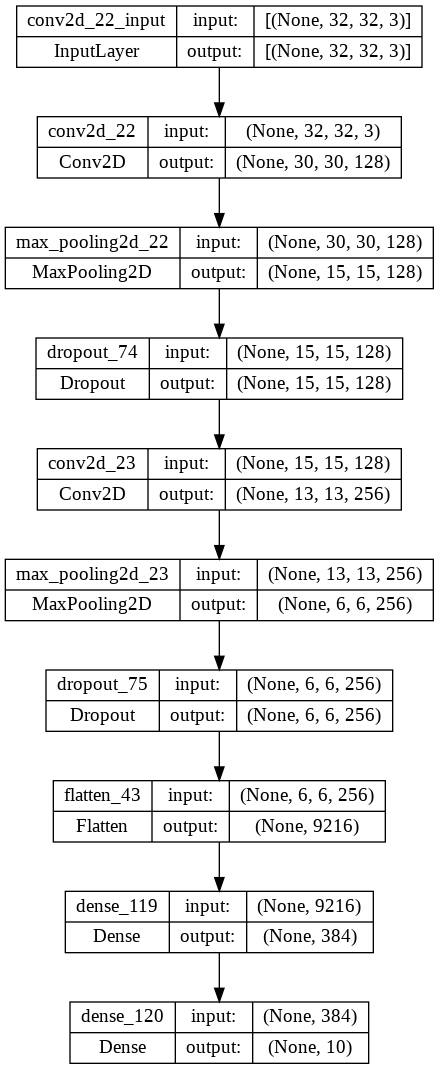

In [247]:
keras.utils.plot_model(model_5_34, "CIFAR10.png", show_shapes=True) 

In [248]:
## Compile

model_5_34.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [250]:
## Train 

history_5_34 = model_5_34.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_34.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 9s 12ms/step - loss: 2.1656 - accuracy: 0.1723 - val_loss: 2.0714 - val_accuracy: 0.1764
Epoch 2/200
704/704 [==============================] - 8s 11ms/step - loss: 2.0126 - accuracy: 0.1849 - val_loss: 1.9756 - val_accuracy: 0.1850
Epoch 3/200
704/704 [==============================] - 7s 11ms/step - loss: 1.9482 - accuracy: 0.2227 - val_loss: 1.8940 - val_accuracy: 0.2428
Epoch 4/200
704/704 [==============================] - 7s 11ms/step - loss: 1.8604 - accuracy: 0.2590 - val_loss: 1.8378 - val_accuracy: 0.2590
Epoch 5/200
704/704 [==============================] - 7s 11ms/step - loss: 1.7992 - accuracy: 0.2743 - val_loss: 1.7691 - val_accuracy: 0.2910
Epoch 6/200
704/704 [==============================] - 7s 11ms/step - loss: 1.7622 - accuracy: 0.2888 - val_loss: 1.7444 - val_accuracy: 0.3078
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7211 - accuracy: 0.3178 - val_loss: 1.6632 - val_accuracy:

In [251]:
## Evaluate

model_5_34 = tf.keras.models.load_model("CNN_model_5_34.h5")
print(f"Test acc: {model_5_34.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.2807 - accuracy: 0.5314
Test acc: 0.531


#### Model 5.4 
Same as Model 4 with regularization

In [107]:
## Build CNN

model_5_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_5_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 6, 6, 256)        

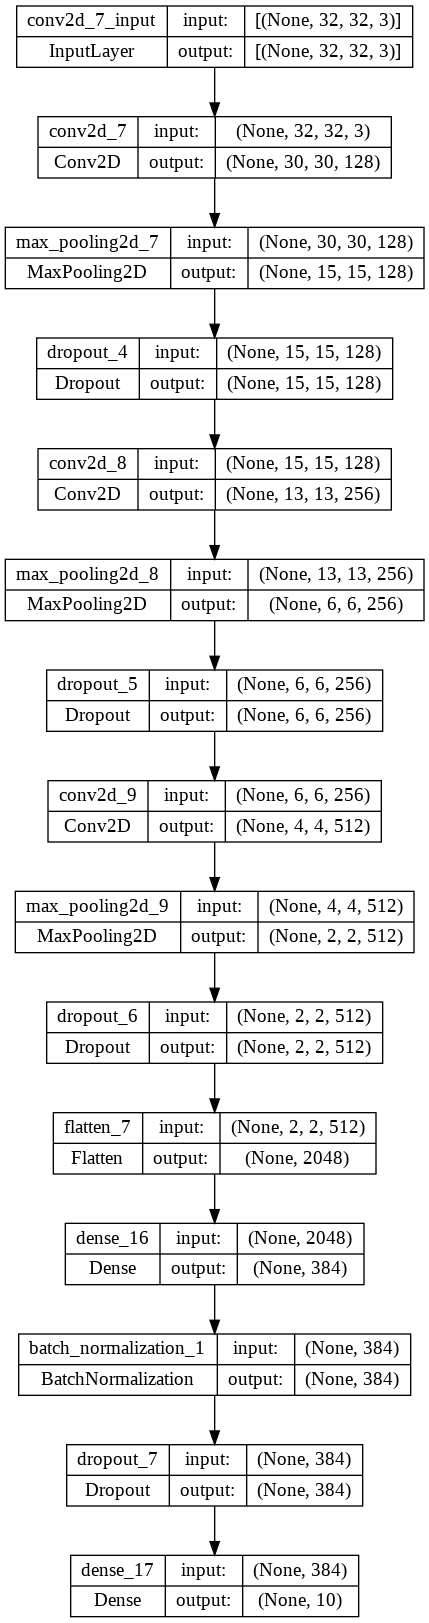

In [108]:
keras.utils.plot_model(model_5_4, "CIFAR10.png", show_shapes=True) 

In [109]:
## Compile
model_5_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [110]:
## Train
history_5_4 = model_5_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 1.7156 - accuracy: 0.4027 - val_loss: 1.4079 - val_accuracy: 0.5372
Epoch 2/200
704/704 [==============================] - 9s 13ms/step - loss: 1.3378 - accuracy: 0.5555 - val_loss: 1.2422 - val_accuracy: 0.5832
Epoch 3/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1917 - accuracy: 0.6149 - val_loss: 1.0631 - val_accuracy: 0.6600
Epoch 4/200
704/704 [==============================] - 9s 13ms/step - loss: 1.1038 - accuracy: 0.6506 - val_loss: 1.0023 - val_accuracy: 0.6816
Epoch 5/200
704/704 [==============================] - 8s 12ms/step - loss: 1.0377 - accuracy: 0.6770 - val_loss: 0.9966 - val_accuracy: 0.6884
Epoch 6/200
704/704 [==============================] - 9s 12ms/step - loss: 0.9887 - accuracy: 0.6921 - val_loss: 0.9328 - val_accuracy: 0.7128
Epoch 7/200
704/704 [==============================] - 8s 12ms/step - loss: 0.9436 - accuracy: 0.7097 - val_loss: 0.8740 - val_accuracy

In [111]:
## Evalute

model_5_4 = tf.keras.models.load_model("CNN_model_5_4.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8871 - accuracy: 0.7229
Test acc: 0.723


#### Model 5.4.1
Same as Model 5.4 + updated dropout (0.1)

In [252]:
## Build CNN

model_5_41 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_5_41.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_76 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_77 (Dropout)        (None, 6, 6, 256)       

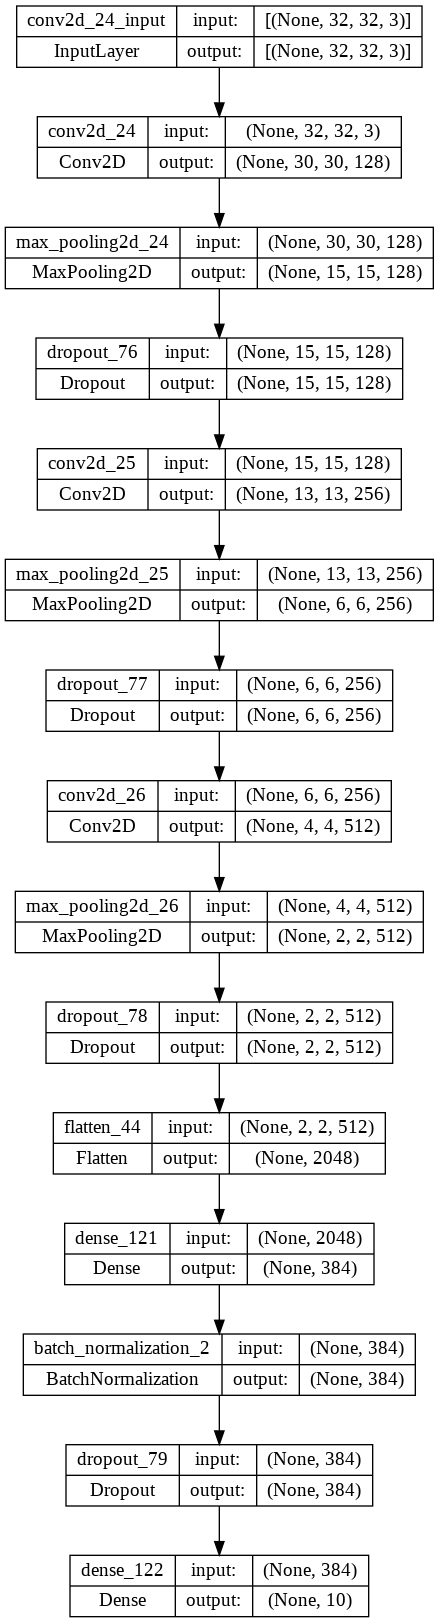

In [253]:
keras.utils.plot_model(model_5_41, "CIFAR10.png", show_shapes=True) 

In [256]:
## Compile
model_5_41.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [257]:
## Train
history_5_41 = model_5_41.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_41.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 1.5531 - accuracy: 0.4630 - val_loss: 1.3561 - val_accuracy: 0.5214
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1435 - accuracy: 0.6217 - val_loss: 1.0662 - val_accuracy: 0.6410
Epoch 3/200
704/704 [==============================] - 9s 12ms/step - loss: 0.9765 - accuracy: 0.6848 - val_loss: 1.0566 - val_accuracy: 0.6578
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 0.8632 - accuracy: 0.7281 - val_loss: 1.0294 - val_accuracy: 0.6758
Epoch 5/200
704/704 [==============================] - 9s 13ms/step - loss: 0.7846 - accuracy: 0.7557 - val_loss: 0.8553 - val_accuracy: 0.7376
Epoch 6/200
704/704 [==============================] - 9s 12ms/step - loss: 0.7153 - accuracy: 0.7822 - val_loss: 0.7965 - val_accuracy: 0.7524
Epoch 7/200
704/704 [==============================] - 8s 12ms/step - loss: 0.6550 - accuracy: 0.8043 - val_loss: 0.7892 - val_accuracy

In [259]:
## Evalute

model_5_41 = tf.keras.models.load_model("CNN_model_5_41.h5")
print(f"Test acc: {model_5_41.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 0.8161 - accuracy: 0.7536
Test acc: 0.754


#### Model 5.4.2
Same as Model 5.4.2 + L2 kernel regularizer

In [260]:
## Build CNN

model_5_42 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.sigmoid)       
])
model_5_42.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_80 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_81 (Dropout)        (None, 6, 6, 256)       

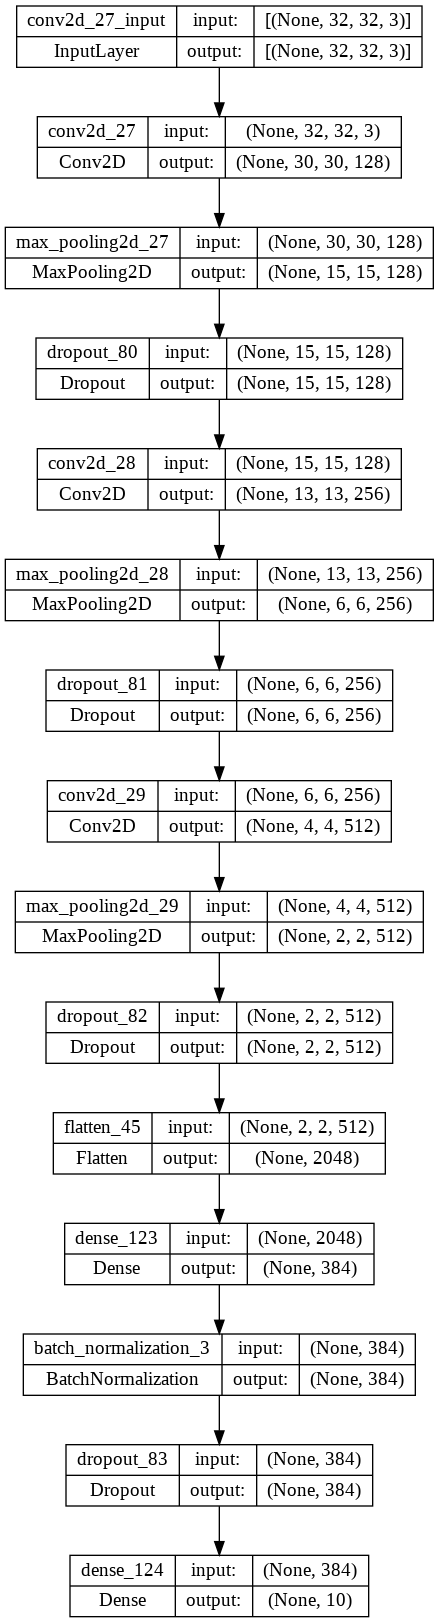

In [261]:
keras.utils.plot_model(model_5_42, "CIFAR10.png", show_shapes=True) 

In [262]:
## Compile
model_5_42.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [263]:
## Train
history_5_42 = model_5_42.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_42.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 1.6179 - accuracy: 0.4284 - val_loss: 1.3327 - val_accuracy: 0.5378
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1817 - accuracy: 0.6008 - val_loss: 1.1712 - val_accuracy: 0.6018
Epoch 3/200
704/704 [==============================] - 9s 12ms/step - loss: 0.9999 - accuracy: 0.6752 - val_loss: 0.9150 - val_accuracy: 0.7062
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 0.8804 - accuracy: 0.7196 - val_loss: 0.8872 - val_accuracy: 0.7146
Epoch 5/200
704/704 [==============================] - 9s 12ms/step - loss: 0.7984 - accuracy: 0.7498 - val_loss: 0.9371 - val_accuracy: 0.6984
Epoch 6/200
704/704 [==============================] - 9s 12ms/step - loss: 0.7310 - accuracy: 0.7738 - val_loss: 0.8065 - val_accuracy: 0.7604
Epoch 7/200
704/704 [==============================] - 8s 12ms/step - loss: 0.6667 - accuracy: 0.7969 - val_loss: 0.8791 - val_accuracy

In [265]:
## Evalute

model_5_42 = tf.keras.models.load_model("CNN_model_5_42.h5")
print(f"Test acc: {model_5_42.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8271 - accuracy: 0.7533
Test acc: 0.753


#### Model 5.4.3
Same as Model 5.4.2 + updated output activation = sigmoid

In [266]:
## Build CNN

model_5_43 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=l2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=l2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.sigmoid)       
])
model_5_43.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_84 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_85 (Dropout)        (None, 6, 6, 256)       

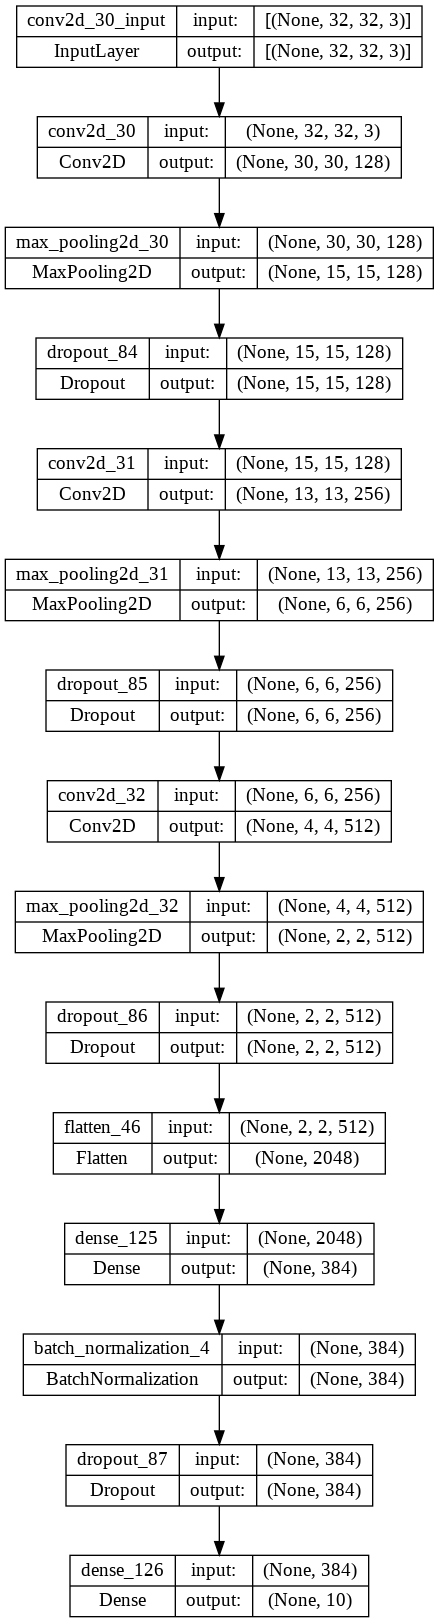

In [267]:
keras.utils.plot_model(model_5_43, "CIFAR10.png", show_shapes=True) 

In [268]:
## Compile
model_5_43.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [269]:
## Train
history_5_43 = model_5_43.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_43.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 11s 14ms/step - loss: 1.7919 - accuracy: 0.3837 - val_loss: 1.7610 - val_accuracy: 0.4104
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.4311 - accuracy: 0.5479 - val_loss: 1.3429 - val_accuracy: 0.5852
Epoch 3/200
704/704 [==============================] - 9s 12ms/step - loss: 1.3049 - accuracy: 0.6157 - val_loss: 1.3036 - val_accuracy: 0.6254
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 1.2339 - accuracy: 0.6488 - val_loss: 1.6388 - val_accuracy: 0.5472
Epoch 5/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1783 - accuracy: 0.6727 - val_loss: 1.2311 - val_accuracy: 0.6578
Epoch 6/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1350 - accuracy: 0.6909 - val_loss: 1.2097 - val_accuracy: 0.6684
Epoch 7/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1036 - accuracy: 0.7050 - val_loss: 1.1288 - val_accuracy

In [270]:
## Evalute

model_5_43 = tf.keras.models.load_model("CNN_model_5_43.h5")
print(f"Test acc: {model_5_43.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.0750 - accuracy: 0.7194
Test acc: 0.719
